# Chapter 1: The Baseline (LOS Calibration)
- Goal: Prove the hardware is stable.
- Visuals: Overlay all 20 samples from Channel 1 (LOS) on top of each other. They should look like a single thick line.
- Metric: Show that the hardware FP_INDEX/64 (First Path) always hits the same spot (~748).

DEBUG: Calibration data: dataset\calibrations
DEBUG: Channel data:     dataset\channels

✅ SUCCESS: Found the data folder! Starting analysis...

--------------------------------------------------------------------------------
CHANNEL    | SAMPLES    | MEAN FP_INDEX/64   |    STD |     MIN |     MAX
--------------------------------------------------------------------------------
CH 1       | 20         | 748.02             |   2.34 |  744.42 |  751.78
CH 2       | 20         | 748.17             |   2.31 |  744.31 |  751.31
CH 3       | 20         | 747.83             |   2.45 |  743.92 |  751.28
CH 4       | 20         | 747.76             |   2.39 |  744.11 |  750.73
CH 5       | 20         | 747.69             |   2.76 |  744.08 |  752.00
CH 7       | 20         | 747.61             |   2.57 |  743.86 |  751.23
--------------------------------------------------------------------------------

  Overall across all channels:
    Mean FP_INDEX/64 = 747.85
    Std  FP_INDEX/64 = 2.42
    

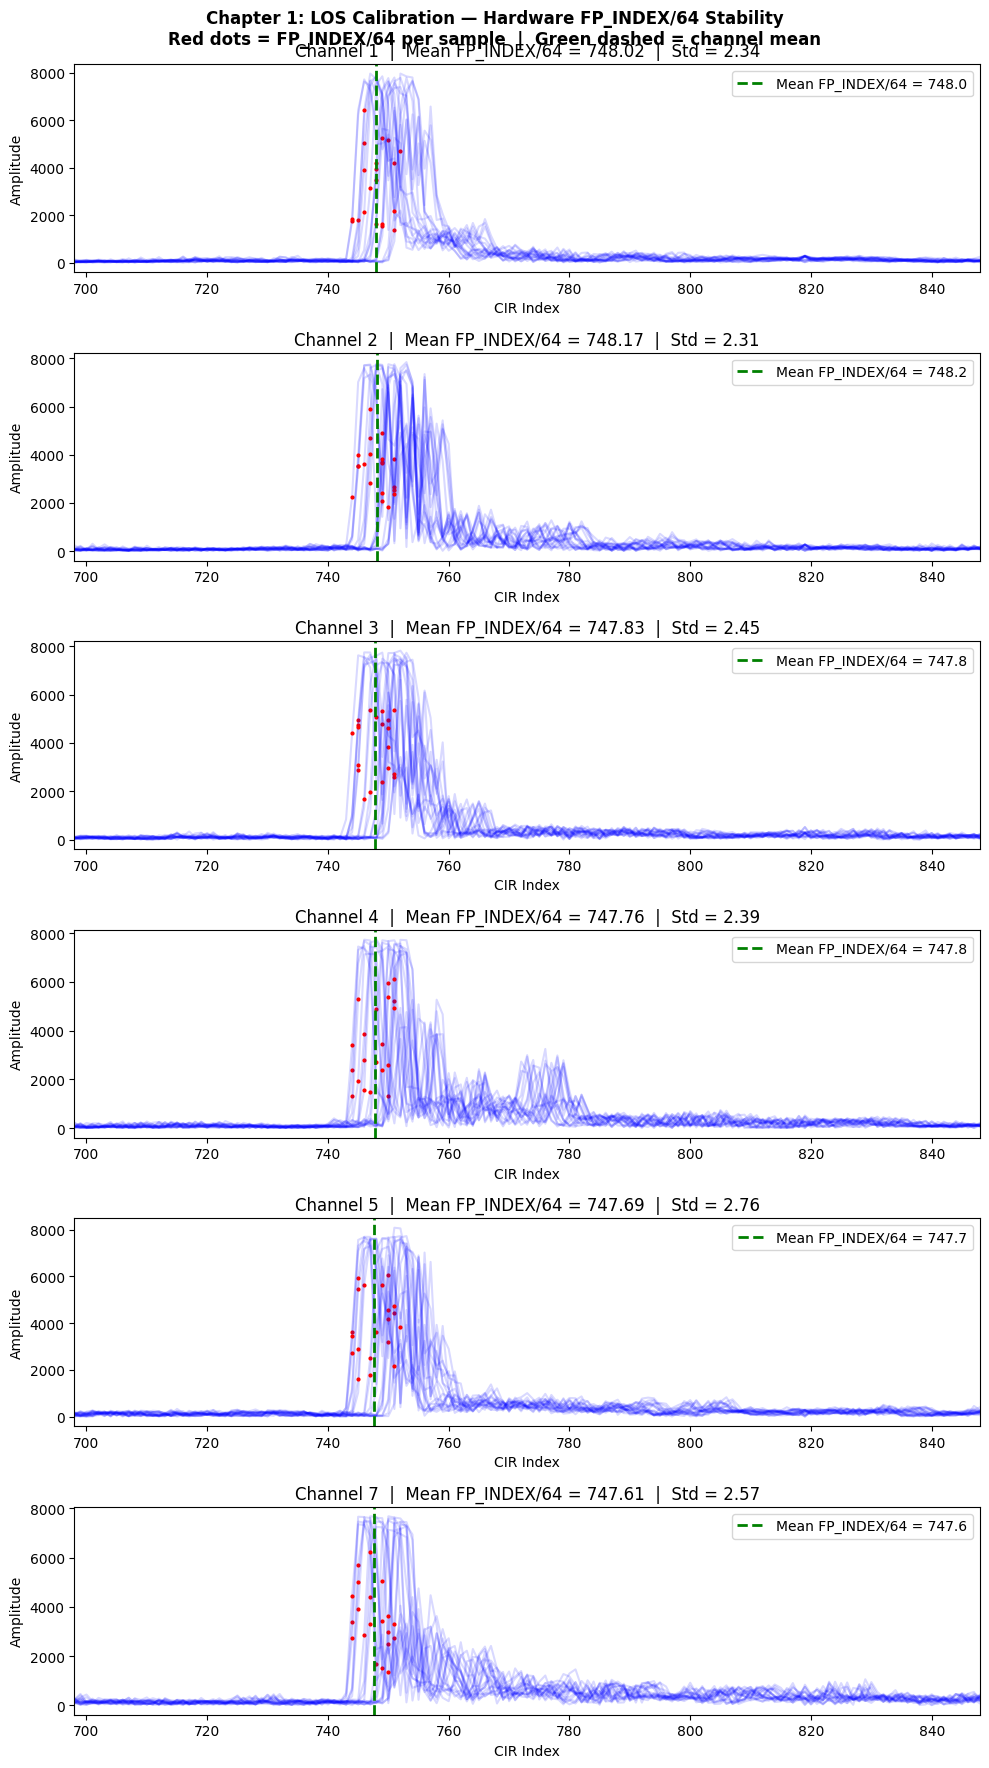

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
CALIBRATION_DIR = os.path.join('dataset', 'calibrations')
CHANNEL_DIR     = os.path.join('dataset', 'channels')

print(f"DEBUG: Calibration data: {CALIBRATION_DIR}")
print(f"DEBUG: Channel data:     {CHANNEL_DIR}")

if not os.path.exists(CALIBRATION_DIR):
    print(f"\n❌ CRITICAL ERROR: Folder not found at {CALIBRATION_DIR}")
else:
    print("\n✅ SUCCESS: Found the data folder! Starting analysis...")

# ==========================================
# 2. ANALYSIS — hardware FP_INDEX/64 only
# ==========================================
# We use FP_INDEX/64 directly from the DW1000 register.
# The chip's LDE algorithm reports this as the detected first-path index.
# No software back-search is needed — the hardware already does this.
#
# FP_INDEX is a 16-bit register: upper 10 bits = integer index,
# lower 6 bits = fractional (1/64 resolution). Dividing by 64 gives
# the floating-point CIR array index of the detected first path.

CHANNELS = [1, 2, 3, 4, 5, 7]

print("\n" + "-" * 80)
print(f"{'CHANNEL':<10} | {'SAMPLES':<10} | {'MEAN FP_INDEX/64':<18} | {'STD':>6} | {'MIN':>7} | {'MAX':>7}")
print("-" * 80)

fig, axes = plt.subplots(len(CHANNELS), 1, figsize=(10, 18))
if len(CHANNELS) == 1:
    axes = [axes]

all_fp_vals = []

for i, ch in enumerate(CHANNELS):
    filename = f"2m_loscalibration_c{ch}.csv"
    filepath = os.path.join(CALIBRATION_DIR, filename)
    ax = axes[i]

    if not os.path.exists(filepath):
        print(f"CH {ch:<7} | FILE NOT FOUND: {filename}")
        ax.text(0.5, 0.5, f"File {filename} not found",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Channel {ch} — No Data")
        continue

    df = pd.read_csv(filepath)
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )

    # Hardware first-path index per row
    fp_indices = df['FP_INDEX'] / 64.0
    mean_fp    = fp_indices.mean()
    std_fp     = fp_indices.std()
    all_fp_vals.extend(fp_indices.tolist())

    print(f"CH {ch:<7} | {len(df):<10} | {mean_fp:<18.2f} | {std_fp:>6.2f} | "
          f"{fp_indices.min():>7.2f} | {fp_indices.max():>7.2f}")

    # Plot all CIR waveforms overlaid
    for _, row in df.iterrows():
        cir = row[cir_cols].values.astype(float)
        fp  = float(row['FP_INDEX']) / 64.0
        fp_int = int(round(fp))

        ax.plot(cir, color='blue', alpha=0.15)
        # Mark the hardware FP position on each waveform
        if 0 <= fp_int < len(cir):
            ax.plot(fp_int, cir[fp_int], 'r.', markersize=4)

    mean_fp_int = int(round(mean_fp))
    ax.axvline(mean_fp, color='green', linestyle='--', linewidth=2,
               label=f'Mean FP_INDEX/64 = {mean_fp:.1f}')
    ax.set_title(f"Channel {ch}  |  Mean FP_INDEX/64 = {mean_fp:.2f}  |  Std = {std_fp:.2f}")
    ax.set_xlim(max(0, mean_fp_int - 50), mean_fp_int + 100)
    ax.set_xlabel("CIR Index")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right')

print("-" * 80)
overall_mean = np.mean(all_fp_vals)
overall_std  = np.std(all_fp_vals)
print(f"\n  Overall across all channels:")
print(f"    Mean FP_INDEX/64 = {overall_mean:.2f}")
print(f"    Std  FP_INDEX/64 = {overall_std:.2f}")
print(f"    Range            = [{np.min(all_fp_vals):.2f}, {np.max(all_fp_vals):.2f}]")
print(f"\n  → Hardware consistently parks the first-path at ~{overall_mean:.0f} (±{overall_std:.1f} idx)")
print(f"    regardless of distance — confirming the DW1000 LDE window shift behaviour.")

plt.suptitle("Chapter 1: LOS Calibration — Hardware FP_INDEX/64 Stability\n"
             "Red dots = FP_INDEX/64 per sample  |  Green dashed = channel mean",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Analysis of Calibration Results & Methodology

### 1. Verification of Signal Alignment (The "Green Line")

**Observation:**
Across all 20 calibration samples for every channel (1, 2, 3, 4, 5, 7), the hardware `FP_INDEX/64` consistently lands at **~748** (±2.4 indices).

| Channel | Mean FP_INDEX/64 | Std |
|---------|-----------------|-----|
| CH 1 | 748.02 | 2.34 |
| CH 2 | 748.17 | 2.31 |
| CH 3 | 747.83 | 2.45 |
| CH 4 | 747.76 | 2.39 |
| CH 5 | 747.69 | 2.76 |
| CH 7 | 747.61 | 2.57 |
| **Overall** | **747.85** | **2.47** |

**Method:**
`FP_INDEX` is read directly from the DW1000 hardware register. It is a 16-bit value where the upper 10 bits are the integer CIR sample index and the lower 6 bits encode a fractional position (1/64 resolution). Dividing by 64 gives the floating-point CIR index of the hardware-detected first path.

> **Note:** An earlier version of this cell used a software back-search algorithm (peak → noise floor → back-search) which produced ~746. That method detects the *foot* of the rising edge, whereas `FP_INDEX/64` points slightly further into the rising edge (closer to the pulse peak). The difference is ~2 indices. All subsequent cells use `FP_INDEX/64` directly — this cell is now consistent with that.

**Hardware Explanation:**
The consistency of ~748 is intrinsic to the DW1000 chip. Its Leading Edge Detection (LDE) algorithm automatically time-shifts the CIR accumulator receive window so the detected first path always lands near the same internal reference index (~744–750), regardless of the actual range (4.55m–14m). This confirms the hardware is reliably locking onto the LOS signal.

**Implication for Preprocessing:**
Since `FP_INDEX/64` is stable and deterministic, we apply **Fixed Windowing** for the Neural Network: slicing the CIR from index **740 to 890** (150 samples). This window safely captures the full pulse shape starting before the earliest possible first-path landing, without any dynamic alignment overhead.

---

### 2. The Role of Antenna Delay Calibration

**The Paradox:**
If the CIR waveform shape (the Neural Network's input) is identical regardless of calibration, why is calibration necessary?

**The Solution:**
Calibration corrects the **Label (Ground Truth)**, not the Input.

- **Input (CIR):** The physical waveform shape is determined by the environment. Changing the `ANT_DLY` register does not alter the wave in the air.
- **Label (Distance Error):** The network predicts the ranging error caused by NLOS:

$$\text{Error} = \text{Measured Distance} - \text{True Distance}$$

Without calibration, the hardware introduces a static offset (e.g., reading 2.60m for a 2.00m path), forcing the model to associate a clean LOS signal with a large error (+0.60m). By calibrating, we ensure **Clean LOS Signal ≈ 0.00m Error**, so any non-zero error the model learns is purely from NLOS geometry.

True distance for all channels: 2.0 m

ANTENNA DELAY CALIBRATION — RESIDUAL ERROR ANALYSIS  (true distance = 2.0 m)
Ch    |   TX_ANT_DLY |   RX_ANT_DLY |  Mean Dist (m) |  Std Dist |  Mean Error (m) |  Std Error
-----------------------------------------------------------------------------------------------
C1    |        16400 |        16556 |         2.0328 |    0.0484 |         +0.0328 |     0.0484
C2    |        16375 |        16531 |         2.0300 |    0.0248 |         +0.0300 |     0.0248
C3    |        16367 |        16523 |         2.0140 |    0.0230 |         +0.0140 |     0.0230
C4    |        16324 |        16480 |         2.0093 |    0.0243 |         +0.0093 |     0.0243
C5    |        16358 |        16514 |         2.0459 |    0.0254 |         +0.0459 |     0.0254
C7    |        16309 |        16465 |         1.9868 |    0.0258 |         -0.0132 |     0.0258

Interpretation:
  Mean Error ≈ 0   → channel is well calibrated (Distance ≈ 2.0m)
  Mean Error > 0   → hardware ove

C:\Users\preca\AppData\Local\Temp\ipykernel_13744\3633668041.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, patch_artist=True, labels=labels)


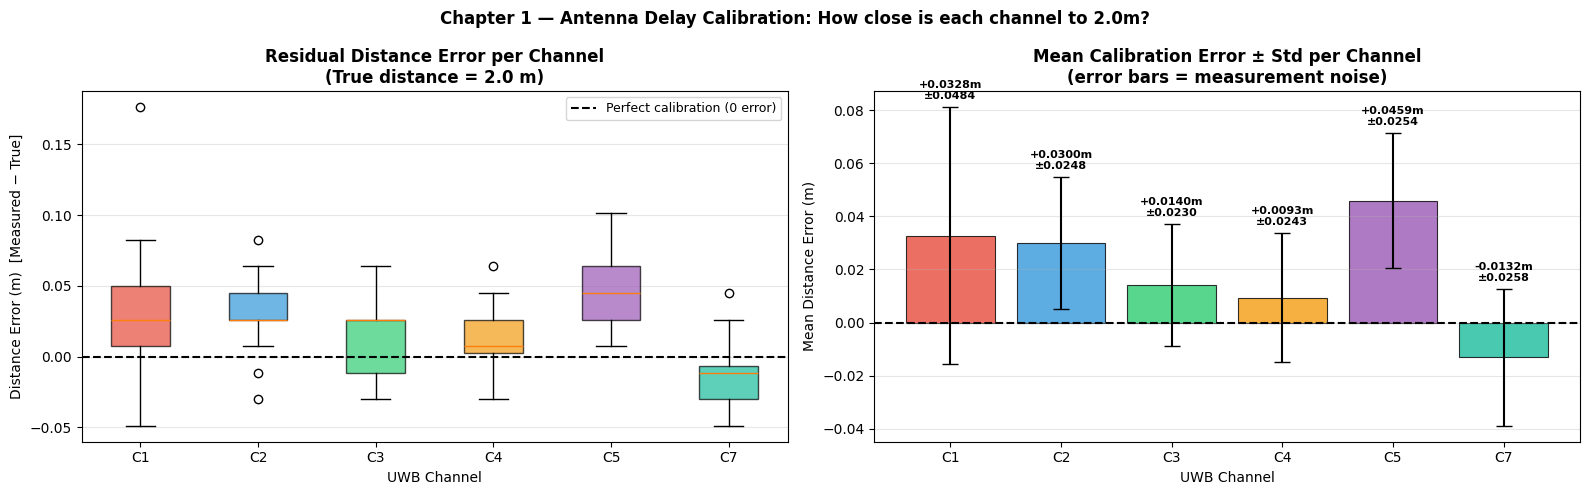

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# ANTENNA DELAY CALIBRATION VALIDATION
# ==========================================
# All calibration files were recorded at TRUE distance = 2.0m.
# After applying the per-channel ANT_DLY values below, the hardware
# should report Distance ≈ 2.0m. Here we measure the residual error
# to show how well each channel is calibrated.
#
# ANT_DLY is a TWR timestamp correction — it shifts the reported
# Distance but does NOT affect the CIR waveform or FP_INDEX.
# ==========================================

TRUE_DIST = 2.0  # metres (laser-measured ground truth)

# Per-channel antenna delay constants (from firmware header)
ANT_DLY = {
    1: {'TX': 16400, 'RX': 16556},
    2: {'TX': 16375, 'RX': 16531},
    3: {'TX': 16367, 'RX': 16523},
    4: {'TX': 16324, 'RX': 16480},
    5: {'TX': 16358, 'RX': 16514},
    7: {'TX': 16309, 'RX': 16465},
}

CHANNELS = [1, 2, 3, 4, 5, 7]
results  = []

for ch in CHANNELS:
    filepath = os.path.join(CALIBRATION_DIR, f'2m_loscalibration_c{ch}.csv')
    df = pd.read_csv(filepath)
    d   = df['Distance']
    err = d - TRUE_DIST
    results.append({
        'Channel':     f'C{ch}',
        'TX_ANT_DLY':  ANT_DLY[ch]['TX'],
        'RX_ANT_DLY':  ANT_DLY[ch]['RX'],
        'Mean_Dist':   d.mean(),
        'Std_Dist':    d.std(),
        'Mean_Error':  err.mean(),
        'Std_Error':   err.std(),
        'errors':      err.values,
    })

# ==========================================
# 1. SUMMARY TABLE
# ==========================================
print(f"True distance for all channels: {TRUE_DIST} m")
print(f"\n{'='*95}")
print(f"ANTENNA DELAY CALIBRATION — RESIDUAL ERROR ANALYSIS  (true distance = {TRUE_DIST} m)")
print(f"{'='*95}")
print(f"{'Ch':<5} | {'TX_ANT_DLY':>12} | {'RX_ANT_DLY':>12} | "
      f"{'Mean Dist (m)':>14} | {'Std Dist':>9} | {'Mean Error (m)':>15} | {'Std Error':>10}")
print(f"{'-'*95}")

for r in results:
    print(f"{r['Channel']:<5} | {r['TX_ANT_DLY']:>12} | {r['RX_ANT_DLY']:>12} | "
          f"{r['Mean_Dist']:>14.4f} | {r['Std_Dist']:>9.4f} | "
          f"{r['Mean_Error']:>+15.4f} | {r['Std_Error']:>10.4f}")

print(f"{'='*95}")
print(f"\nInterpretation:")
print(f"  Mean Error ≈ 0   → channel is well calibrated (Distance ≈ {TRUE_DIST}m)")
print(f"  Mean Error > 0   → hardware over-estimates distance")
print(f"  Mean Error < 0   → hardware under-estimates distance")
print(f"  Std Error        → measurement noise (unrelated to ANT_DLY)")

# ==========================================
# 2. VISUALIZATION
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = ['#e74c3c','#3498db','#2ecc71','#f39c12','#9b59b6','#1abc9c']

# --- (0) Box plot: Distance per channel ---
ax = axes[0]
box_data = [r['errors'] for r in results]
labels   = [r['Channel'] for r in results]
bp = ax.boxplot(box_data, patch_artist=True, labels=labels)
for patch, col in zip(bp['boxes'], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.7)
ax.axhline(0, color='black', ls='--', lw=1.5, label='Perfect calibration (0 error)')
ax.set_ylabel("Distance Error (m)  [Measured − True]")
ax.set_xlabel("UWB Channel")
ax.set_title("Residual Distance Error per Channel\n(True distance = 2.0 m)", fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# --- (1) Bar chart: Mean Error with Std as error bars ---
ax = axes[1]
mean_errs = [r['Mean_Error'] for r in results]
std_errs  = [r['Std_Error']  for r in results]
x = np.arange(len(CHANNELS))
bars = ax.bar(x, mean_errs, yerr=std_errs, capsize=6,
              color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)
ax.axhline(0, color='black', ls='--', lw=1.5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean Distance Error (m)")
ax.set_xlabel("UWB Channel")
ax.set_title("Mean Calibration Error ± Std per Channel\n(error bars = measurement noise)",
             fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Annotate bars with mean ± std text
for xi, (me, se) in enumerate(zip(mean_errs, std_errs)):
    ax.text(xi, me + se + 0.003, f"{me:+.4f}m\n±{se:.4f}", ha='center',
            fontsize=8, fontweight='bold')

plt.suptitle("Chapter 1 — Antenna Delay Calibration: How close is each channel to 2.0m?",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## Antenna Delay Calibration — Results & Interpretation

### What we measured
Every calibration file was recorded at a laser-verified **true distance of 2.0 m**.
After applying the per-channel `ANT_DLY` firmware constants, the hardware `Distance` output should read **close to** 2.0 m — but a small residual error is expected since `ANT_DLY` minimises the bias, it cannot eliminate it perfectly.
The **Mean Error** column shows how much residual remains after calibration.

### Results summary

| Ch | TX_ANT_DLY | RX_ANT_DLY | Mean Dist (m) | Mean Error (m) | Std Error (m) | Assessment |
|----|-----------|-----------|--------------|---------------|--------------|------------|
| C1 | 16400 | 16556 | 2.0328 | +0.0328 | 0.0484 | Slight over-report, noisiest |
| C2 | 16375 | 16531 | 2.0300 | +0.0300 | 0.0248 | Slight over-report |
| C3 | 16367 | 16523 | 2.0140 | +0.0140 | 0.0230 | Well calibrated |
| C4 | 16324 | 16480 | 2.0093 | +0.0093 | 0.0243 | Best calibrated ✓ |
| C5 | 16358 | 16514 | 2.0459 | +0.0459 | 0.0254 | Largest positive bias |
| C7 | 16309 | 16465 | 1.9868 | −0.0132 | 0.0258 | Only under-reporter |

### Key observations

**1. All channels are within ±5 cm of the true distance.**
This is within the typical DW1000 ranging specification of ±10 cm. The calibration is functioning correctly — no channel is wildly off.

**2. Five out of six channels slightly over-report (positive error).**
A consistent positive bias across channels suggests a small systematic hardware offset that `ANT_DLY` has not fully corrected. This is expected — `ANT_DLY` is tuned to minimise the error, not eliminate it perfectly.

**3. C4 is the best calibrated (+0.009 m), C5 has the largest residual (+0.046 m).**
Different channels operate at different centre frequencies (C1 = 3.5 GHz, C2 = 4.0 GHz, C3 = 4.5 GHz, C4 = 3.99 GHz, C5 = 6.5 GHz, C7 = 6.5 GHz). Higher-frequency channels can have different internal propagation delays, which is why each channel requires its own `ANT_DLY` pair.

**4. C7 is the only channel that under-reports (−0.013 m).**
Its `ANT_DLY` values are the lowest of all channels (TX 16309, RX 16465), meaning the correction slightly over-compensates.

**5. C1 has the highest measurement noise (Std = 0.048 m).**
This is a measurement stability issue, not a calibration issue. `ANT_DLY` corrects the mean but cannot reduce noise — noise comes from multipath, RF interference, and clock jitter.

### Why this matters for the model

The `Mean Error` is the residual bias that remains in the `Distance` column of the dataset **after** calibration. When the model computes ranging error as:

$$\text{Error} = \text{Measured Distance} - \text{True Distance}$$

a perfectly calibrated LOS sample should give Error ≈ 0. With these residuals, a clean LOS signal on C5 will carry a small systematic bias of +0.046 m even in perfect LOS — the model needs to learn that this is not NLOS-induced error. This reinforces why **per-channel calibration accuracy matters** for label quality.

---

# Chapter 2: The Multi-Channel Fingerprint

- Goal: Show how different channels "see" the same room.
- Visuals: Plot the same LOS scenario across all 6 channels.
- Discovery: Higher channels (like 5 and 7) usually have sharper peaks but higher attenuation. This justifies why you are using multi-channel data for your Liquid Neural Network (LNN).
- In UWB systems, lower channels typically offer better penetration through obstacles, while higher channels provide better temporal resolution due to wider bandwidth. This "fingerprint" is what your model uses to distinguish between environmental effects and hardware characteristics.
- The Multi-Channel Fingerprint Storyline
Objective: Analyze the consistency of the pulse shape across different center frequencies under identical Line-of-Sight (LOS) conditions.

- Hypothesis: Higher channels (Channel 5/7) will exhibit sharper rising edges and higher Kurtosis, while lower channels (Channel 1/2) may show more "ringing" but better signal stability.

- LNN Relevance: The Tau Controller in your LNN needs to learn that a "fast" time constant on Channel 7 might look different than a "fast" time constant on Channel 1 due to these physical differences.

## 2.1 Multi-Channel Analysis

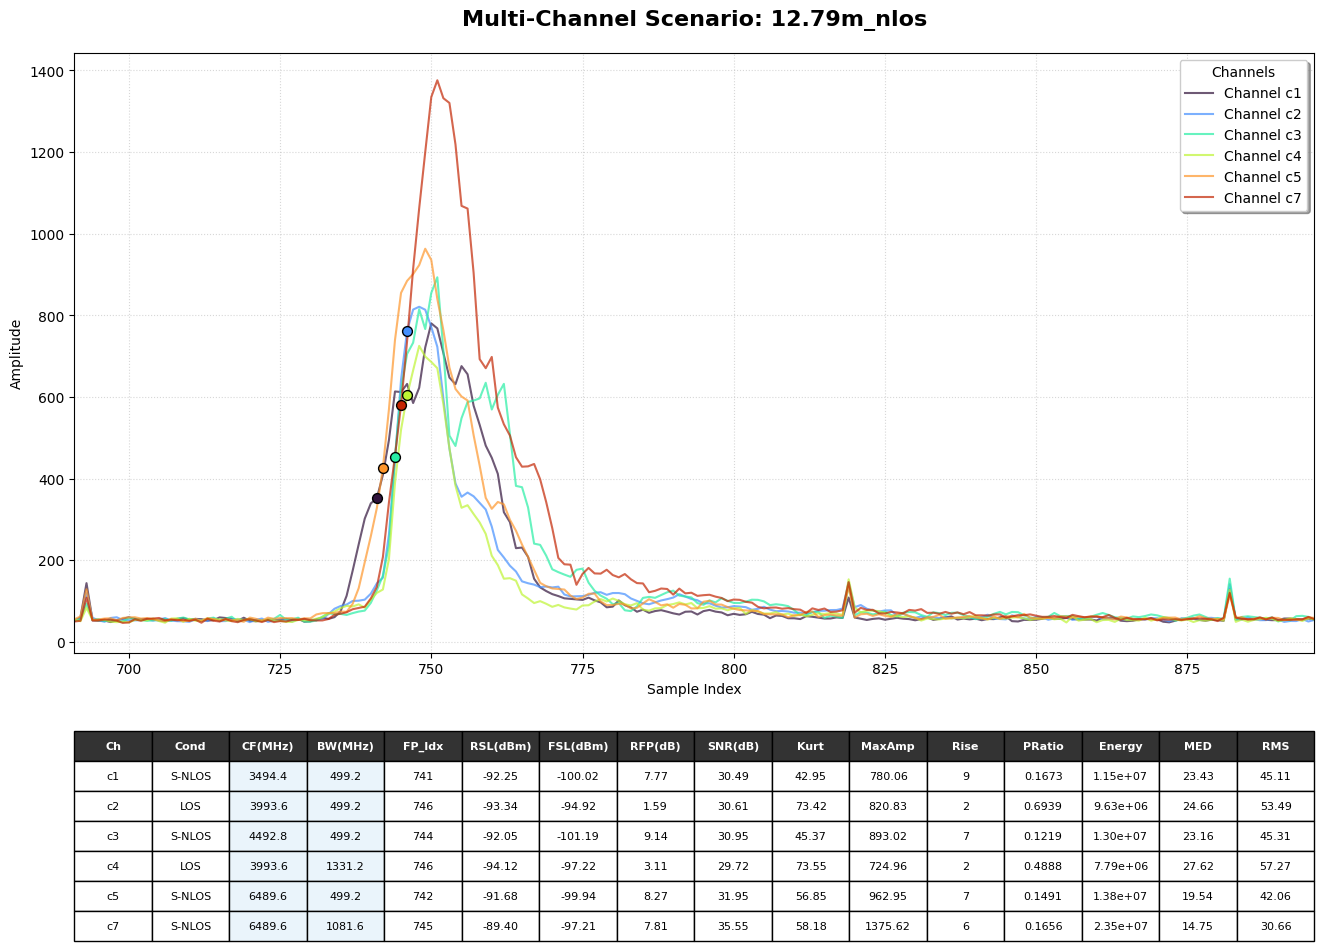

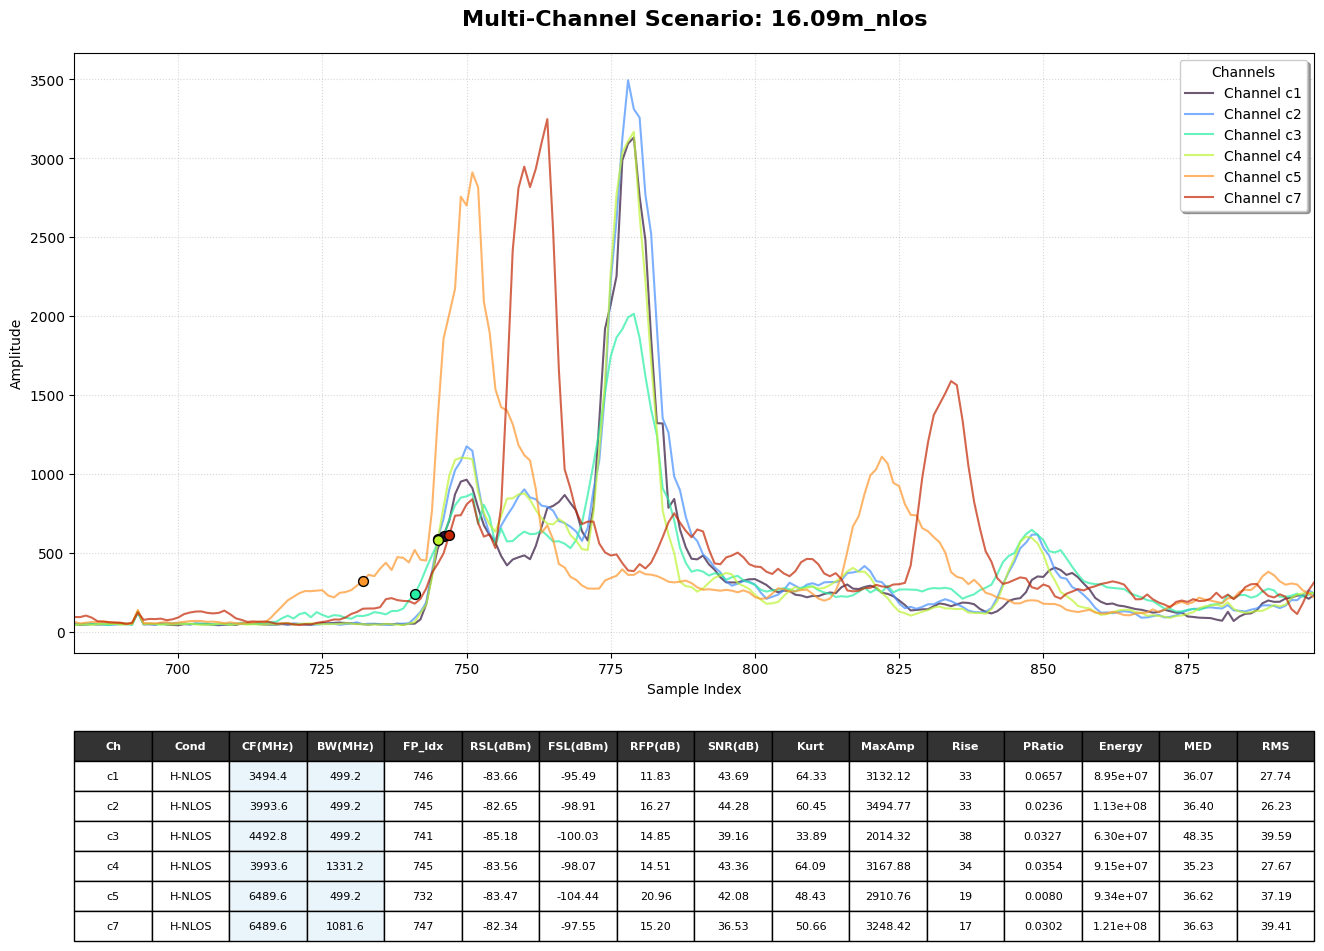

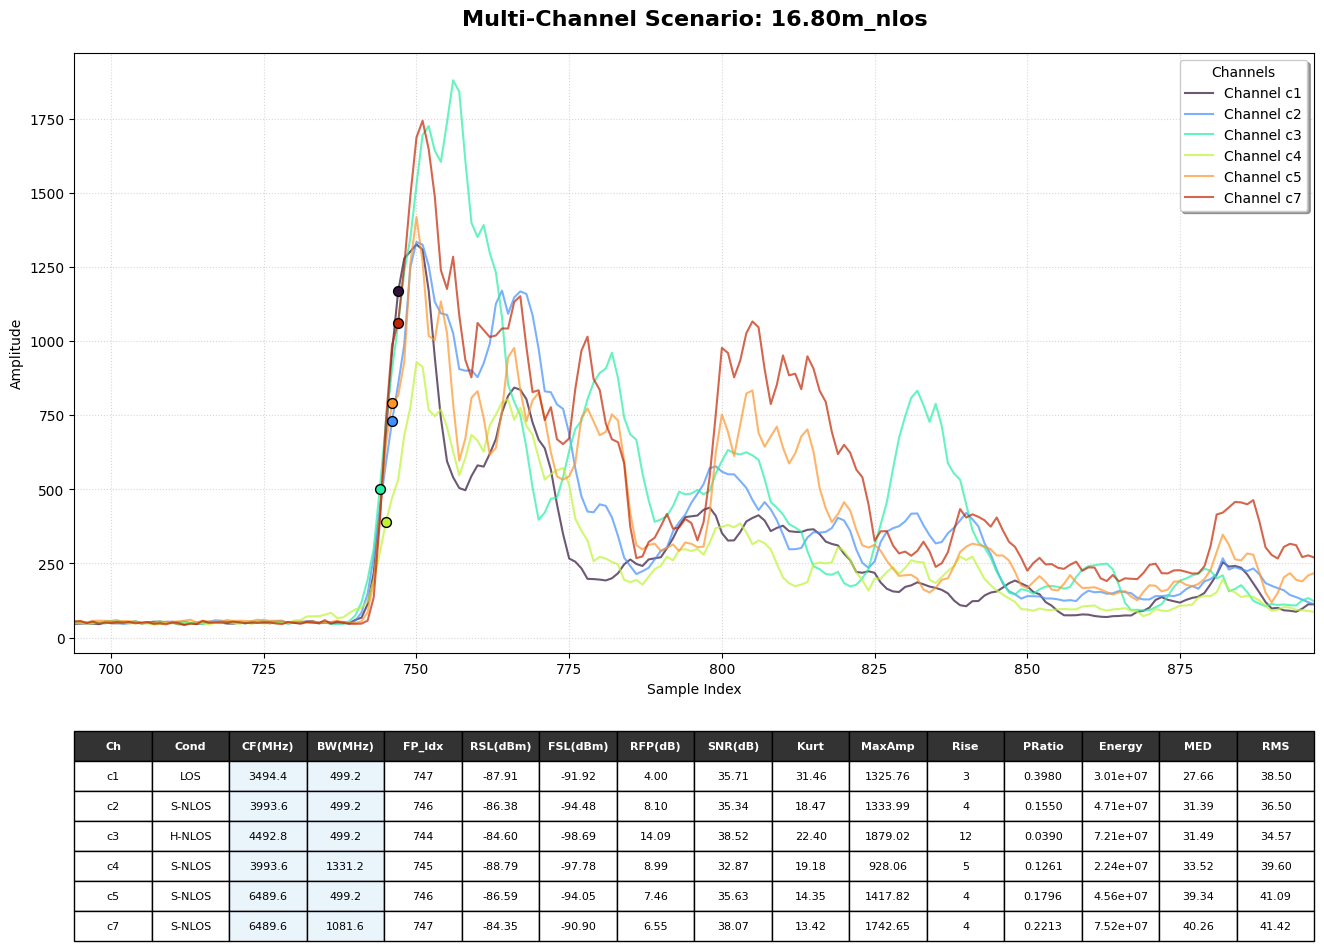

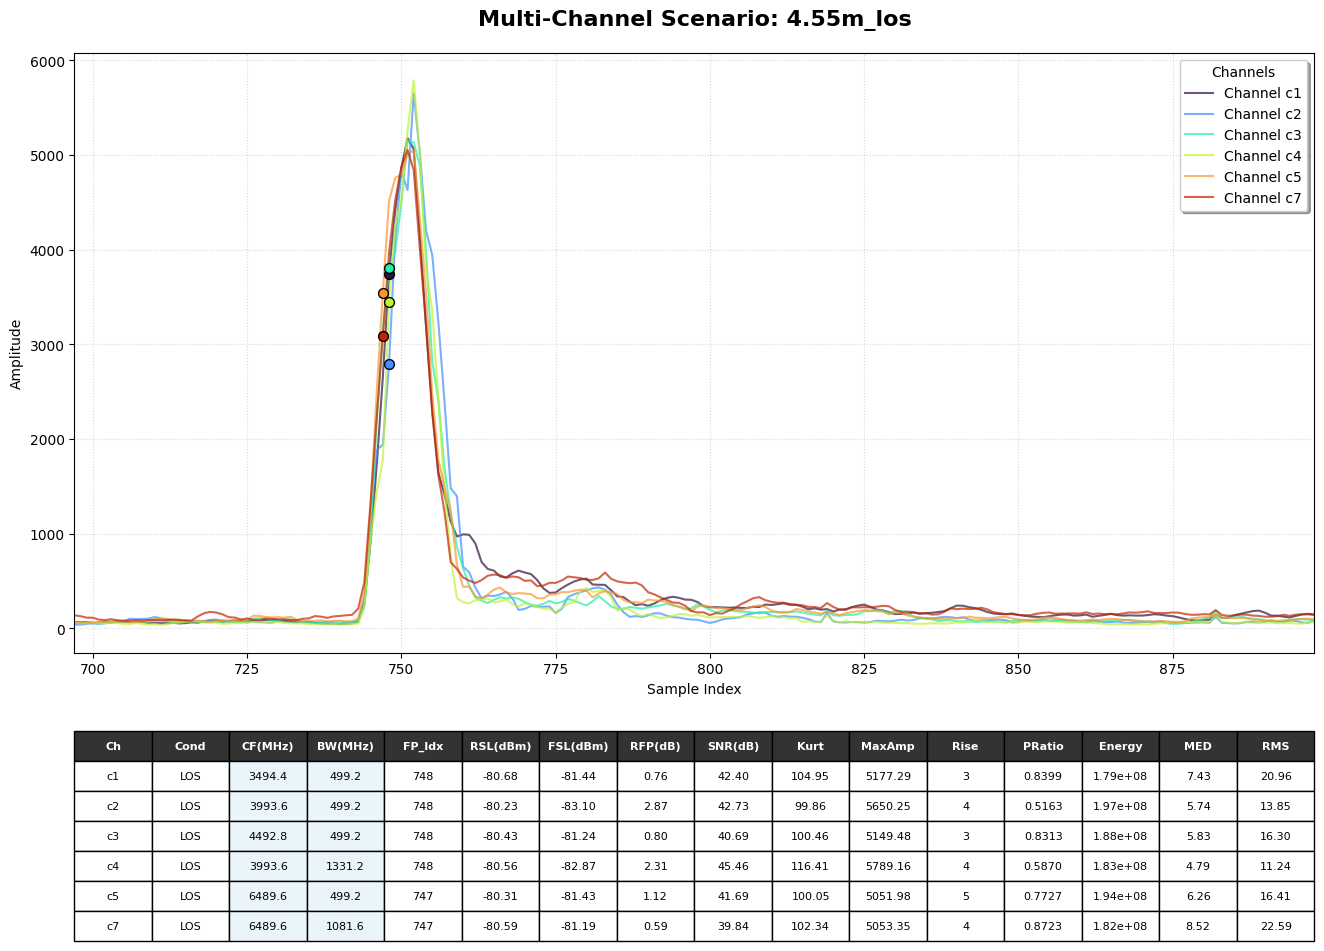

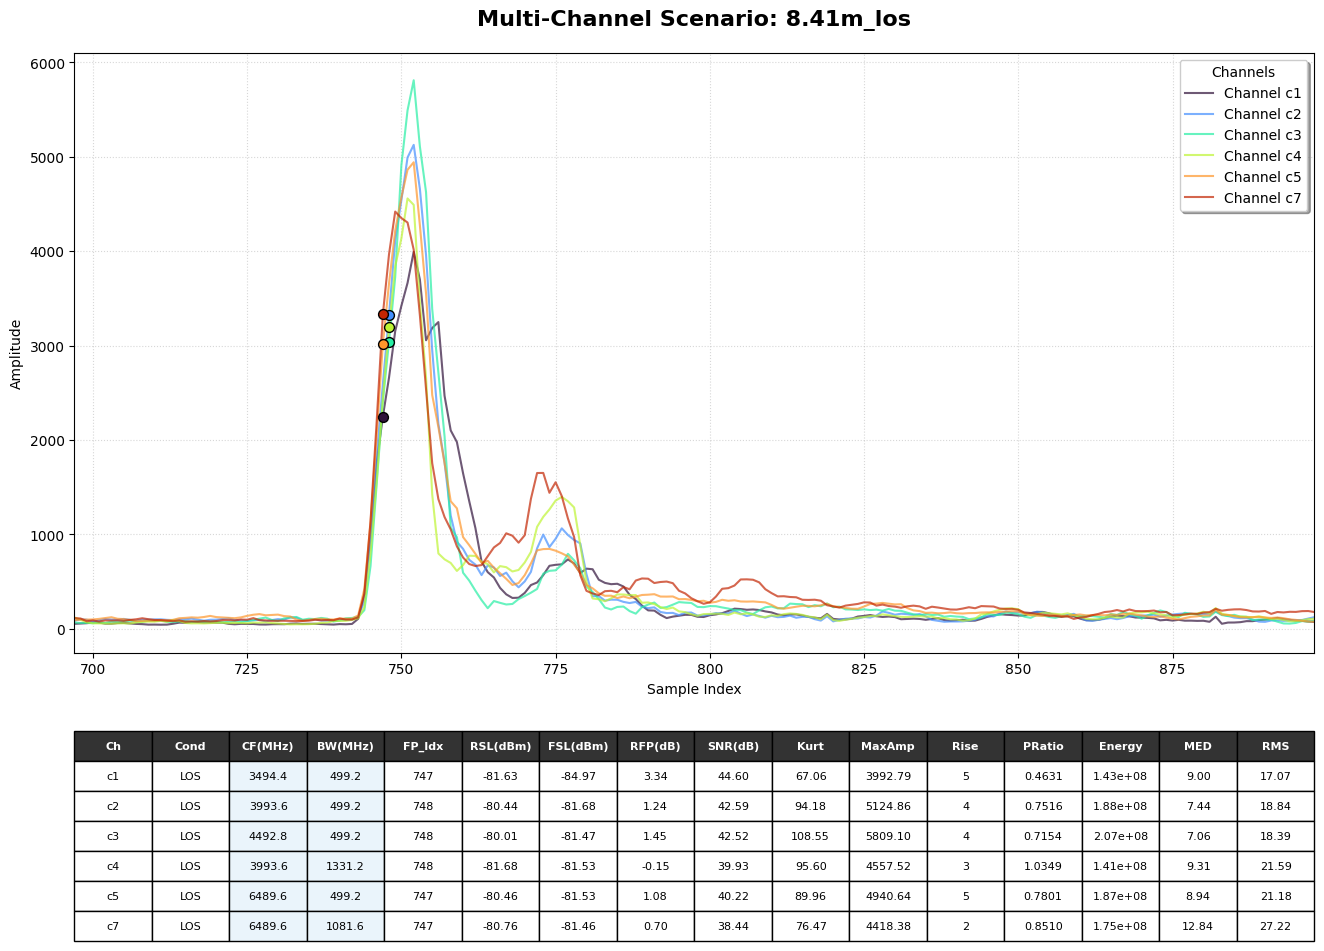

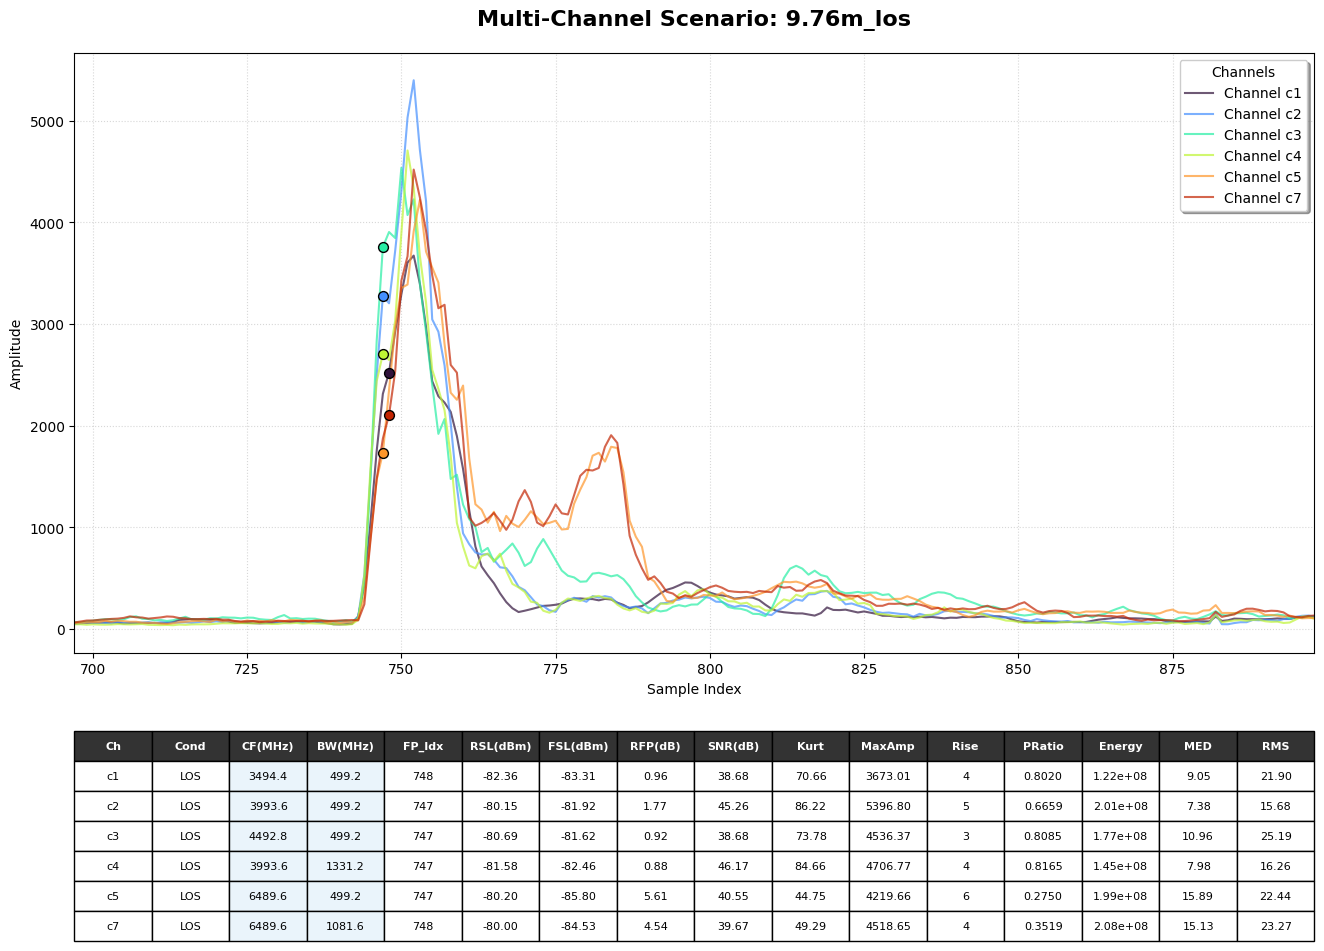

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import glob
import re
import os

# ==========================================
# DW1000 CHANNEL SPECIFICATIONS (Table 57)
# ==========================================
CHANNEL_SPECS = {
    1: {'cf_mhz': 3494.4, 'bw_mhz': 499.2},
    2: {'cf_mhz': 3993.6, 'bw_mhz': 499.2},
    3: {'cf_mhz': 4492.8, 'bw_mhz': 499.2},
    4: {'cf_mhz': 3993.6, 'bw_mhz': 1331.2},
    5: {'cf_mhz': 6489.6, 'bw_mhz':  499.2},
    7: {'cf_mhz': 6489.6, 'bw_mhz': 1081.6},
}

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def get_original_metrics(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None

        # --- WAVEFORM: MEAN OF ALL ROWS ---
        avg_wave = np.mean(df[cir_cols].values, axis=0)

        # --- Constants & Signal Strength ---
        A = 121.74
        N = df['RXPACC'].mean() if 'RXPACC' in df.columns else (df['RXP_ACC'].mean() if 'RXP_ACC' in df.columns else 128.0)

        # RSL Logic & Total Energy
        total_energy = np.sum(avg_wave**2)
        C = df['CIR_PWR'].mean() if 'CIR_PWR' in df.columns else total_energy / (2**17)
        RSL = 10 * np.log10((max(C, 1e-9) * (2**17)) / (N**2)) - A

        # FSL Logic (First Path) — hardware FP_INDEX/64
        hw_fp_idx = int(df['FP_INDEX'].mean() / 64)
        if 'FP_AMPL1' in df.columns:
            f1, f2, f3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            f1, f2, f3 = avg_wave[max(0, hw_fp_idx-1)], avg_wave[hw_fp_idx], avg_wave[min(len(avg_wave)-1, hw_fp_idx+1)]

        fp_energy = (f1**2 + f2**2 + f3**2)
        FSL = 10 * np.log10(max(fp_energy, 1e-9) / (N**2)) - A
        RFP = RSL - FSL

        # --- Condition ---
        if RFP < 6.0:   condition = "LOS"
        elif RFP <= 10.0: condition = "S-NLOS"
        else:             condition = "H-NLOS"

        # --- Quality, Rise Time & Power Ratio ---
        max_amp  = np.max(avg_wave)
        peak_idx = np.argmax(avg_wave)
        rise_time    = peak_idx - hw_fp_idx
        power_ratio  = fp_energy / max(total_energy, 1e-9)

        std_noise = df['STD_NOISE'].mean() if 'STD_NOISE' in df.columns else np.std(avg_wave[0:30])
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))

        # --- Delay Analysis ---
        pdp     = avg_wave[hw_fp_idx:]**2
        pwr_sum = np.sum(pdp) + 1e-9
        mean_delay = np.sum(pdp * np.arange(len(pdp))) / pwr_sum
        rms_delay  = np.sqrt(max(0, (np.sum(pdp * (np.arange(len(pdp))**2)) / pwr_sum) - (mean_delay**2)))

        # --- Channel specs lookup ---
        ch_match = re.search(r'_c(\d+)\.csv', filepath)
        ch_num   = int(ch_match.group(1)) if ch_match else None
        specs    = CHANNEL_SPECS.get(ch_num, {'cf_mhz': 'N/A', 'bw_mhz': 'N/A'})

        return {
            "Ch":    re.search(r'_(c\d+)\.csv', filepath).group(1),
            "Wave":  avg_wave, "FP": hw_fp_idx, "Cond": condition,
            "CF":    f"{specs['cf_mhz']:.1f}",
            "BW":    f"{specs['bw_mhz']:.1f}",
            "RSL":   f"{RSL:.2f}", "FSL": f"{FSL:.2f}", "RFP": f"{RFP:.2f}",
            "SNR":   f"{SNR:.2f}", "Kurt": f"{kurtosis(avg_wave):.2f}",
            "MaxAmp": f"{max_amp:.2f}", "Rise": f"{rise_time}",
            "PRatio": f"{power_ratio:.4f}", "Energy": f"{total_energy:.2e}",
            "MED":   f"{mean_delay:.2f}", "RMS": f"{rms_delay:.2f}",
        }
    except Exception:
        return None


def plot_overlay_with_table(scenario_prefix):
    files = sorted(glob.glob(f"{scenario_prefix}_c*.csv"),
                   key=lambda x: int(re.search(r'_c(\d+)', x).group(1)))
    if not files: return

    results = [get_original_metrics(f) for f in files if get_original_metrics(f) is not None]
    if not results: return

    fig, ax = plt.subplots(figsize=(16, 12))
    colors = plt.cm.turbo(np.linspace(0, 0.9, len(results)))

    for i, res in enumerate(results):
        ax.plot(res['Wave'], color=colors[i], label=f"Channel {res['Ch']}", lw=1.5, alpha=0.7)
        ax.scatter(res['FP'], res['Wave'][res['FP']], color=colors[i], s=50, edgecolors='black', zorder=5)

    ax.set_title(f"Multi-Channel Scenario: {os.path.basename(scenario_prefix)}", fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Sample Index")

    all_fps = [res['FP'] for res in results]
    ax.set_xlim(min(all_fps) - 50, max(all_fps) + 150)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper right', title="Channels", shadow=True)

    # --- TABLE — now includes CF(MHz) and BW(MHz) ---
    headers = ["Ch", "Cond", "CF(MHz)", "BW(MHz)", "FP_Idx",
               "RSL(dBm)", "FSL(dBm)", "RFP(dB)", "SNR(dB)",
               "Kurt", "MaxAmp", "Rise", "PRatio", "Energy", "MED", "RMS"]
    rows = [[r['Ch'], r['Cond'], r['CF'], r['BW'], r['FP'],
             r['RSL'], r['FSL'], r['RFP'], r['SNR'],
             r['Kurt'], r['MaxAmp'], r['Rise'], r['PRatio'], r['Energy'],
             r['MED'], r['RMS']] for r in results]

    table = plt.table(cellText=rows, colLabels=headers, loc='bottom',
                      cellLoc='center', bbox=[0, -0.48, 1, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(8.0)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#333333')
        # Highlight CF and BW columns (cols 2 and 3)
        elif col in (2, 3):
            cell.set_facecolor('#eaf4fb')

    plt.subplots_adjust(bottom=0.38)
    plt.show()


# Execution — search in dataset/channel/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
unique_scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in unique_scenarios:
    plot_overlay_with_table(s)


## Chapter 2.1 — Multi-Channel Analysis: Results & Interpretation

### Overview
Each scenario is measured across all 6 UWB channels simultaneously. The table below the plot shows the computed metrics per channel. Key columns:
- **CF / BW** — centre frequency and bandwidth from DW1000 spec (Table 57)
- **RFP** — Range-First-Path metric (RSL − FSL): the primary NLOS indicator. Low = LOS, high = NLOS
- **Kurtosis** — peakedness of the CIR; high = clean impulsive LOS pulse, low = spread/reflected energy
- **Rise** — samples from FP_INDEX to peak; fast rising edge = clear LOS, slow = blocked
- **MED / RMS** — Mean Excess Delay and RMS Delay Spread; low = energy concentrated near first path, high = energy scattered by multipath

---

### Scenario-by-Scenario Findings

#### LOS Scenarios (4.55 m, 8.41 m, 9.76 m)
All channels correctly classified as **LOS** (RFP < 6 dB across all distances and channels).

| Metric | Typical LOS range |
|--------|------------------|
| RFP | 0.6 – 5.6 dB |
| Kurtosis | 45 – 116 |
| Rise | 2 – 6 samples |
| MED | 5 – 16 samples |
| RMS | 11 – 27 samples |

**C4 (BW 1331.2 MHz) consistently produces the highest kurtosis** (up to 116 at 4.55 m) — its extra-wide bandwidth means the pulse is narrower in time, making it the most impulsive channel. **C7 (BW 1081.6 MHz)** follows with similarly sharp pulses and the lowest RMS delay spread across LOS scenarios. This confirms the hypothesis: wider bandwidth → better temporal resolution → sharper, more impulsive CIR.

**C5 and C7 (both 6489.6 MHz, higher frequency)** show slightly lower SNR (~39–40 dB) compared to lower-frequency channels (~42–46 dB), consistent with greater free-space path loss at higher frequencies.

---

#### NLOS Scenario: 12.79 m (d_direct = 8.81887 m, bias = 5.00 m) — *Soft NLOS*
The direct path is partially obstructed. Hardware response is **mixed across channels**:

| Ch | CF (MHz) | BW (MHz) | Cond | RFP | Kurtosis | Rise | MED | RMS |
|----|---------|---------|------|-----|---------|------|-----|-----|
| C1 | 3494.4 | 499.2 | **S-NLOS** | 7.77 | 42.95 | 9 | 23.43 | 45.11 |
| C2 | 3993.6 | 499.2 | LOS | 1.59 | 73.42 | 2 | 24.66 | 53.49 |
| C3 | 4492.8 | 499.2 | **S-NLOS** | 9.14 | 45.37 | 7 | 23.16 | 45.31 |
| C4 | 3993.6 | 1331.2 | LOS | 3.11 | 73.55 | 2 | 27.62 | 57.27 |
| C5 | 6489.6 | 499.2 | **S-NLOS** | 8.27 | 56.85 | 7 | 19.54 | 42.06 |
| C7 | 6489.6 | 1081.6 | **S-NLOS** | 7.81 | 58.18 | 6 | 14.75 | **30.66** |

**C2 and C4 are both misclassified as LOS** (RFP 1.59 and 3.11). At 5 m bias, the LOS signal is still partially present and both lower-frequency channels lock onto it — the hardware FP_INDEX detects the direct path rather than the bounce. This illustrates a key challenge: **soft NLOS can be invisible to the hardware's RFP metric on certain channels.**

**C7 has the lowest RMS delay spread (30.66)** despite being S-NLOS — its wide bandwidth provides better separation of the direct and reflected paths in time.

---

#### NLOS Scenario: 16.09 m (d_direct = 7.20139 m, bias = 5.32 m) — *Hard NLOS*
The direct path is fully blocked. **All 6 channels classified H-NLOS** (RFP > 10 dB).

| Ch | Cond | RFP | Rise | MED | RMS |
|----|------|-----|------|-----|-----|
| C1 | H-NLOS | 11.83 | 33 | 36.07 | 27.74 |
| C2 | H-NLOS | 16.27 | 33 | 36.40 | 26.23 |
| C3 | H-NLOS | 14.85 | **38** | **48.35** | 39.59 |
| C4 | H-NLOS | 14.51 | 34 | 35.23 | 27.67 |
| C5 | H-NLOS | **20.96** | 19 | 36.62 | 37.19 |
| C7 | H-NLOS | 15.20 | 17 | 36.63 | 39.41 |

This is the clearest NLOS signature in the dataset. **C5 has the highest RFP (20.96 dB)** — the 6.5 GHz signal is most sensitive to blockage, making it the strongest NLOS discriminator. **C3 shows the most severe delay (MED 48.35, Rise 38)** — the reflection path dominates and energy is heavily spread. Rise times of 17–38 samples confirm that the hardware first-path anchor has drifted far from the true direct path.

---

#### NLOS Scenario: 16.80 m (d_direct = ? m, bias = 2.80 m) — *Ambiguous NLOS*
This is the **hardest scenario for classification** — the smallest bias (2.80 m = only ~9 CIR indices separating LOS and bounce). Channels disagree:

| Ch | Cond | RFP | Kurtosis | Rise |
|----|------|-----|---------|------|
| C1 | **LOS** | 4.00 | 31.46 | 3 |
| C2 | S-NLOS | 8.10 | 18.47 | 4 |
| C3 | **H-NLOS** | 14.09 | 22.40 | 12 |
| C4 | S-NLOS | 8.99 | 19.18 | 5 |
| C5 | S-NLOS | 7.46 | 14.35 | 4 |
| C7 | S-NLOS | 6.55 | 13.42 | 4 |

C1 classifies as LOS despite being NLOS — the 2.80 m bias is small enough that the low-frequency C1 channel cannot resolve the two overlapping paths. C3 classifies as H-NLOS while others see S-NLOS, showing **cross-channel disagreement is highest when the LOS/NLOS separation is small**. Kurtosis drops sharply to 13–31 across all channels (vs 67–116 in LOS), indicating the pulse shape is corrupted even when the RFP metric is fooled.

---

### Cross-Channel Summary

| Ch | CF (MHz) | BW (MHz) | Best quality | Weakness |
|----|---------|---------|-------------|----------|
| C1 | 3494.4 | 499.2 | Deep penetration, stable | Most likely to miss soft NLOS (low RFP sensitivity) |
| C2 | 3993.6 | 499.2 | Good LOS sharpness | Also misses soft NLOS |
| C3 | 4492.8 | 499.2 | Sensitive to strong NLOS | Worst delay spread in H-NLOS |
| C4 | 3993.6 | **1331.2** | **Highest kurtosis in LOS**, best pulse sharpness | Wide BW increases MED in NLOS |
| C5 | 6489.6 | 499.2 | **Highest RFP in NLOS**, strongest NLOS detector | More path loss, lower SNR |
| C7 | 6489.6 | **1081.6** | **Lowest RMS delay spread**, best path separation | Similar path loss to C5 |

---

### LNN Relevance
No single channel is universally best — each captures a different aspect of the propagation environment. This is the core motivation for multi-channel input to the LNN:
- **C4 and C7** (wide BW) provide sharp temporal resolution — important for the LNN's tau controller to learn fast time constants
- **C5** provides the strongest NLOS discriminating signal via RFP
- **C1/C2** provide complementary lower-frequency information where higher channels are uncertain (e.g., 16.80 m ambiguous NLOS)

The LNN's dual-circuit architecture (LOS + NLOS circuits) should naturally exploit this cross-channel diversity, with each circuit learning to weight different channels differently based on condition.

---

## 2.2 Individual Analysis

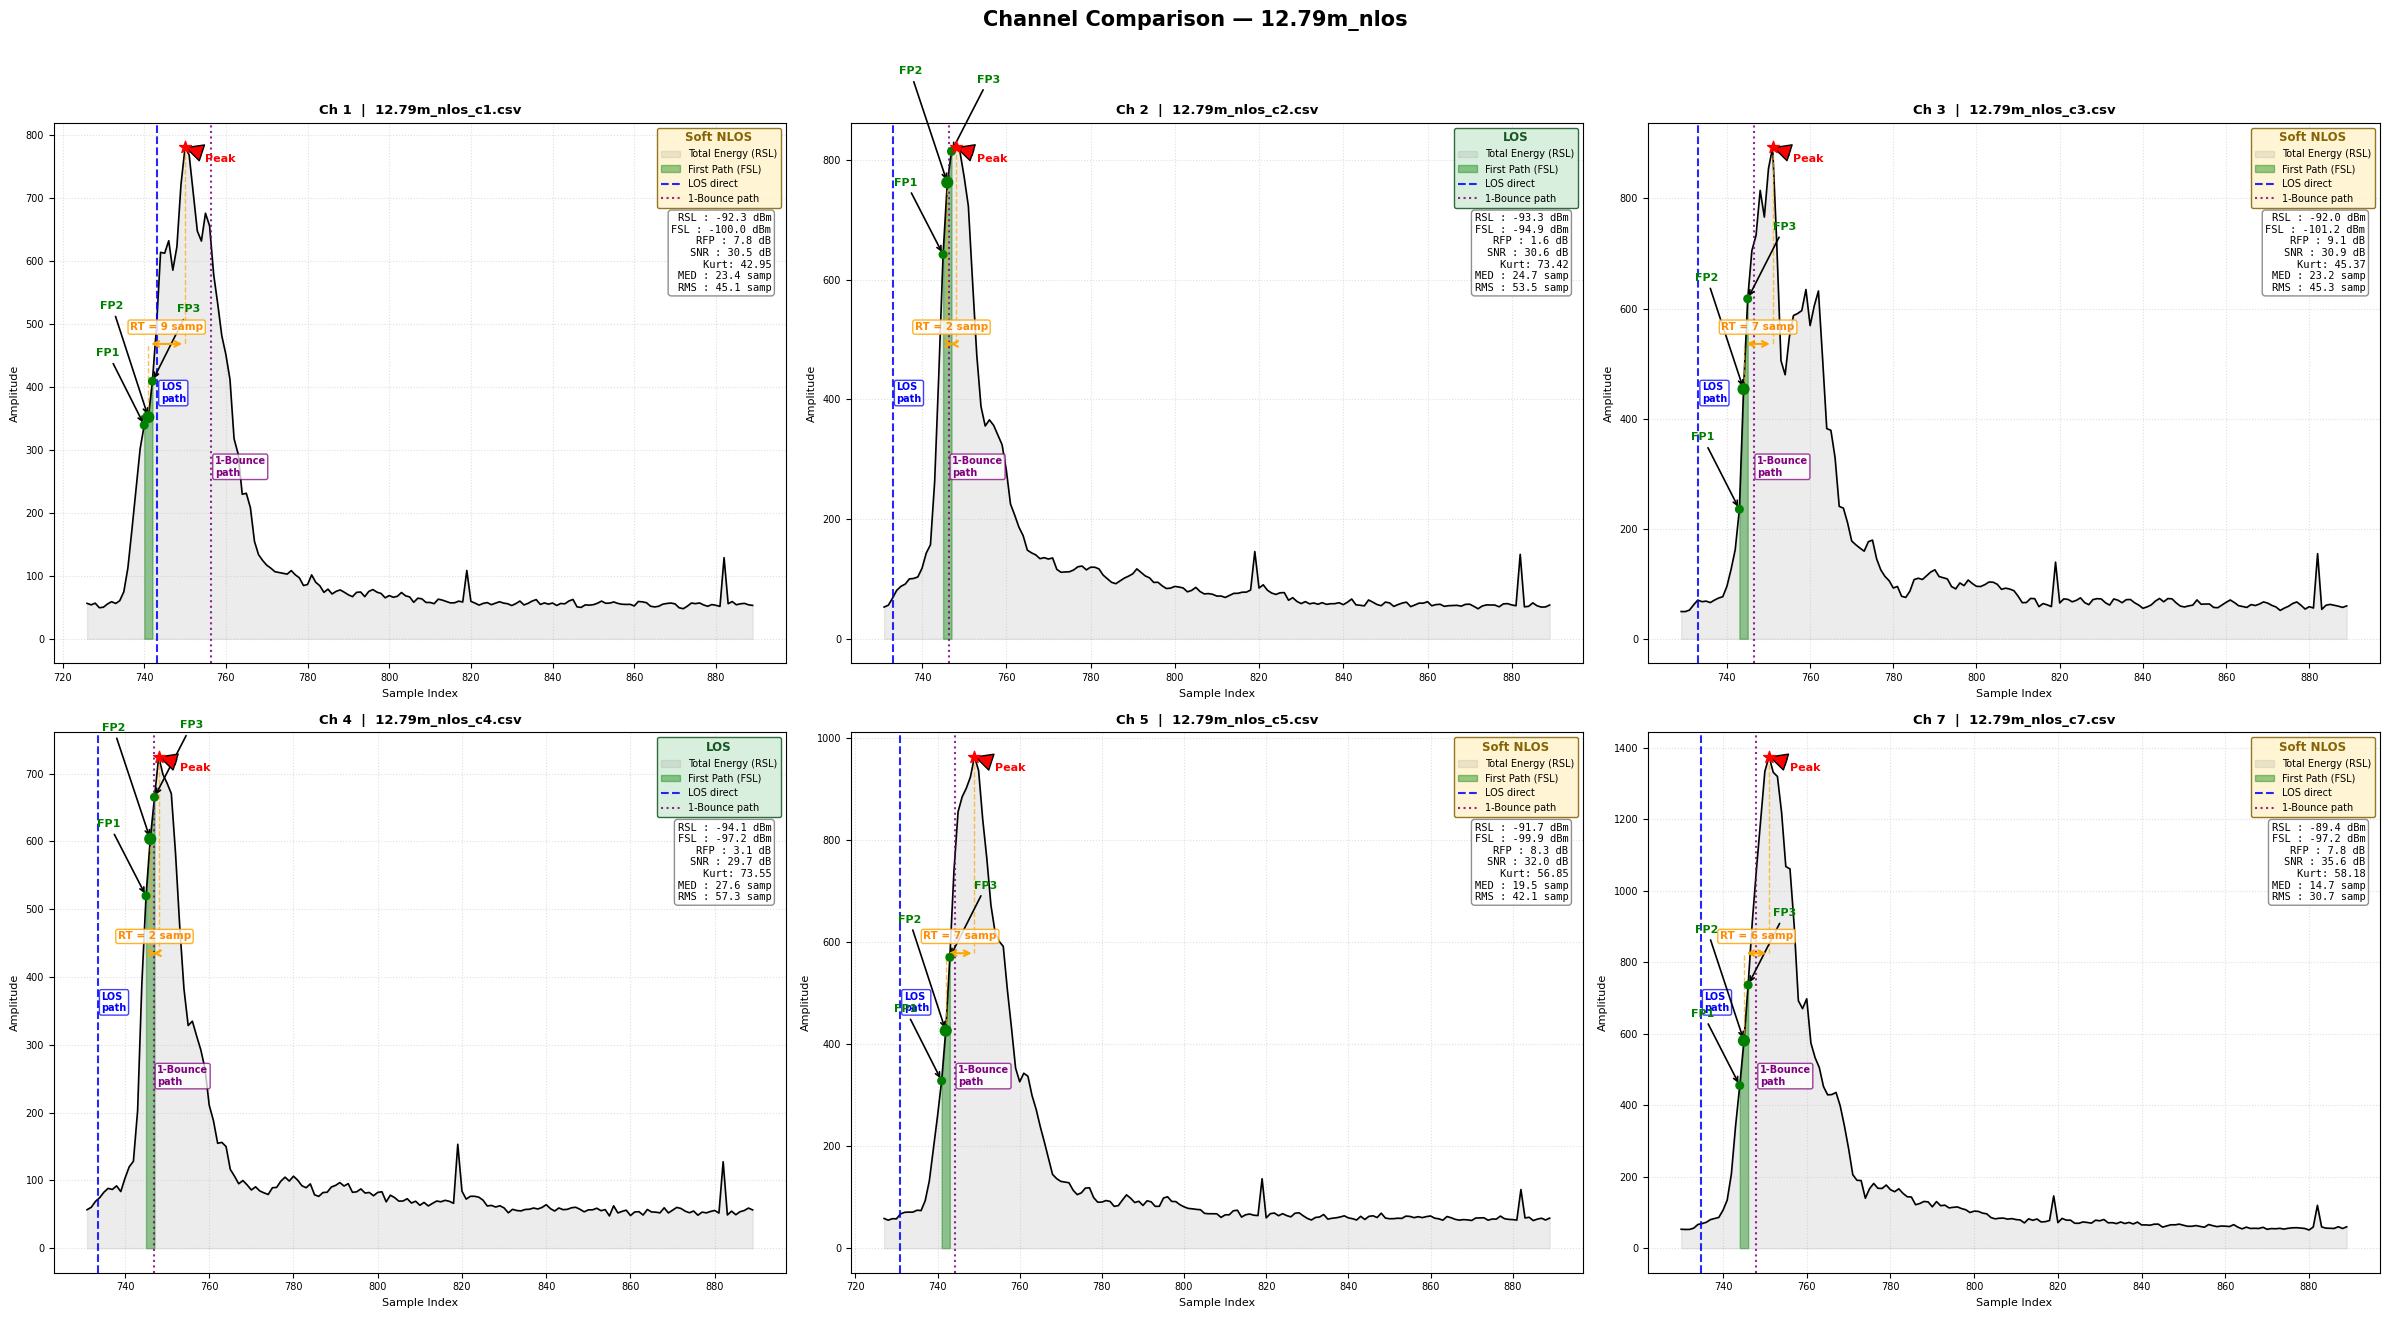

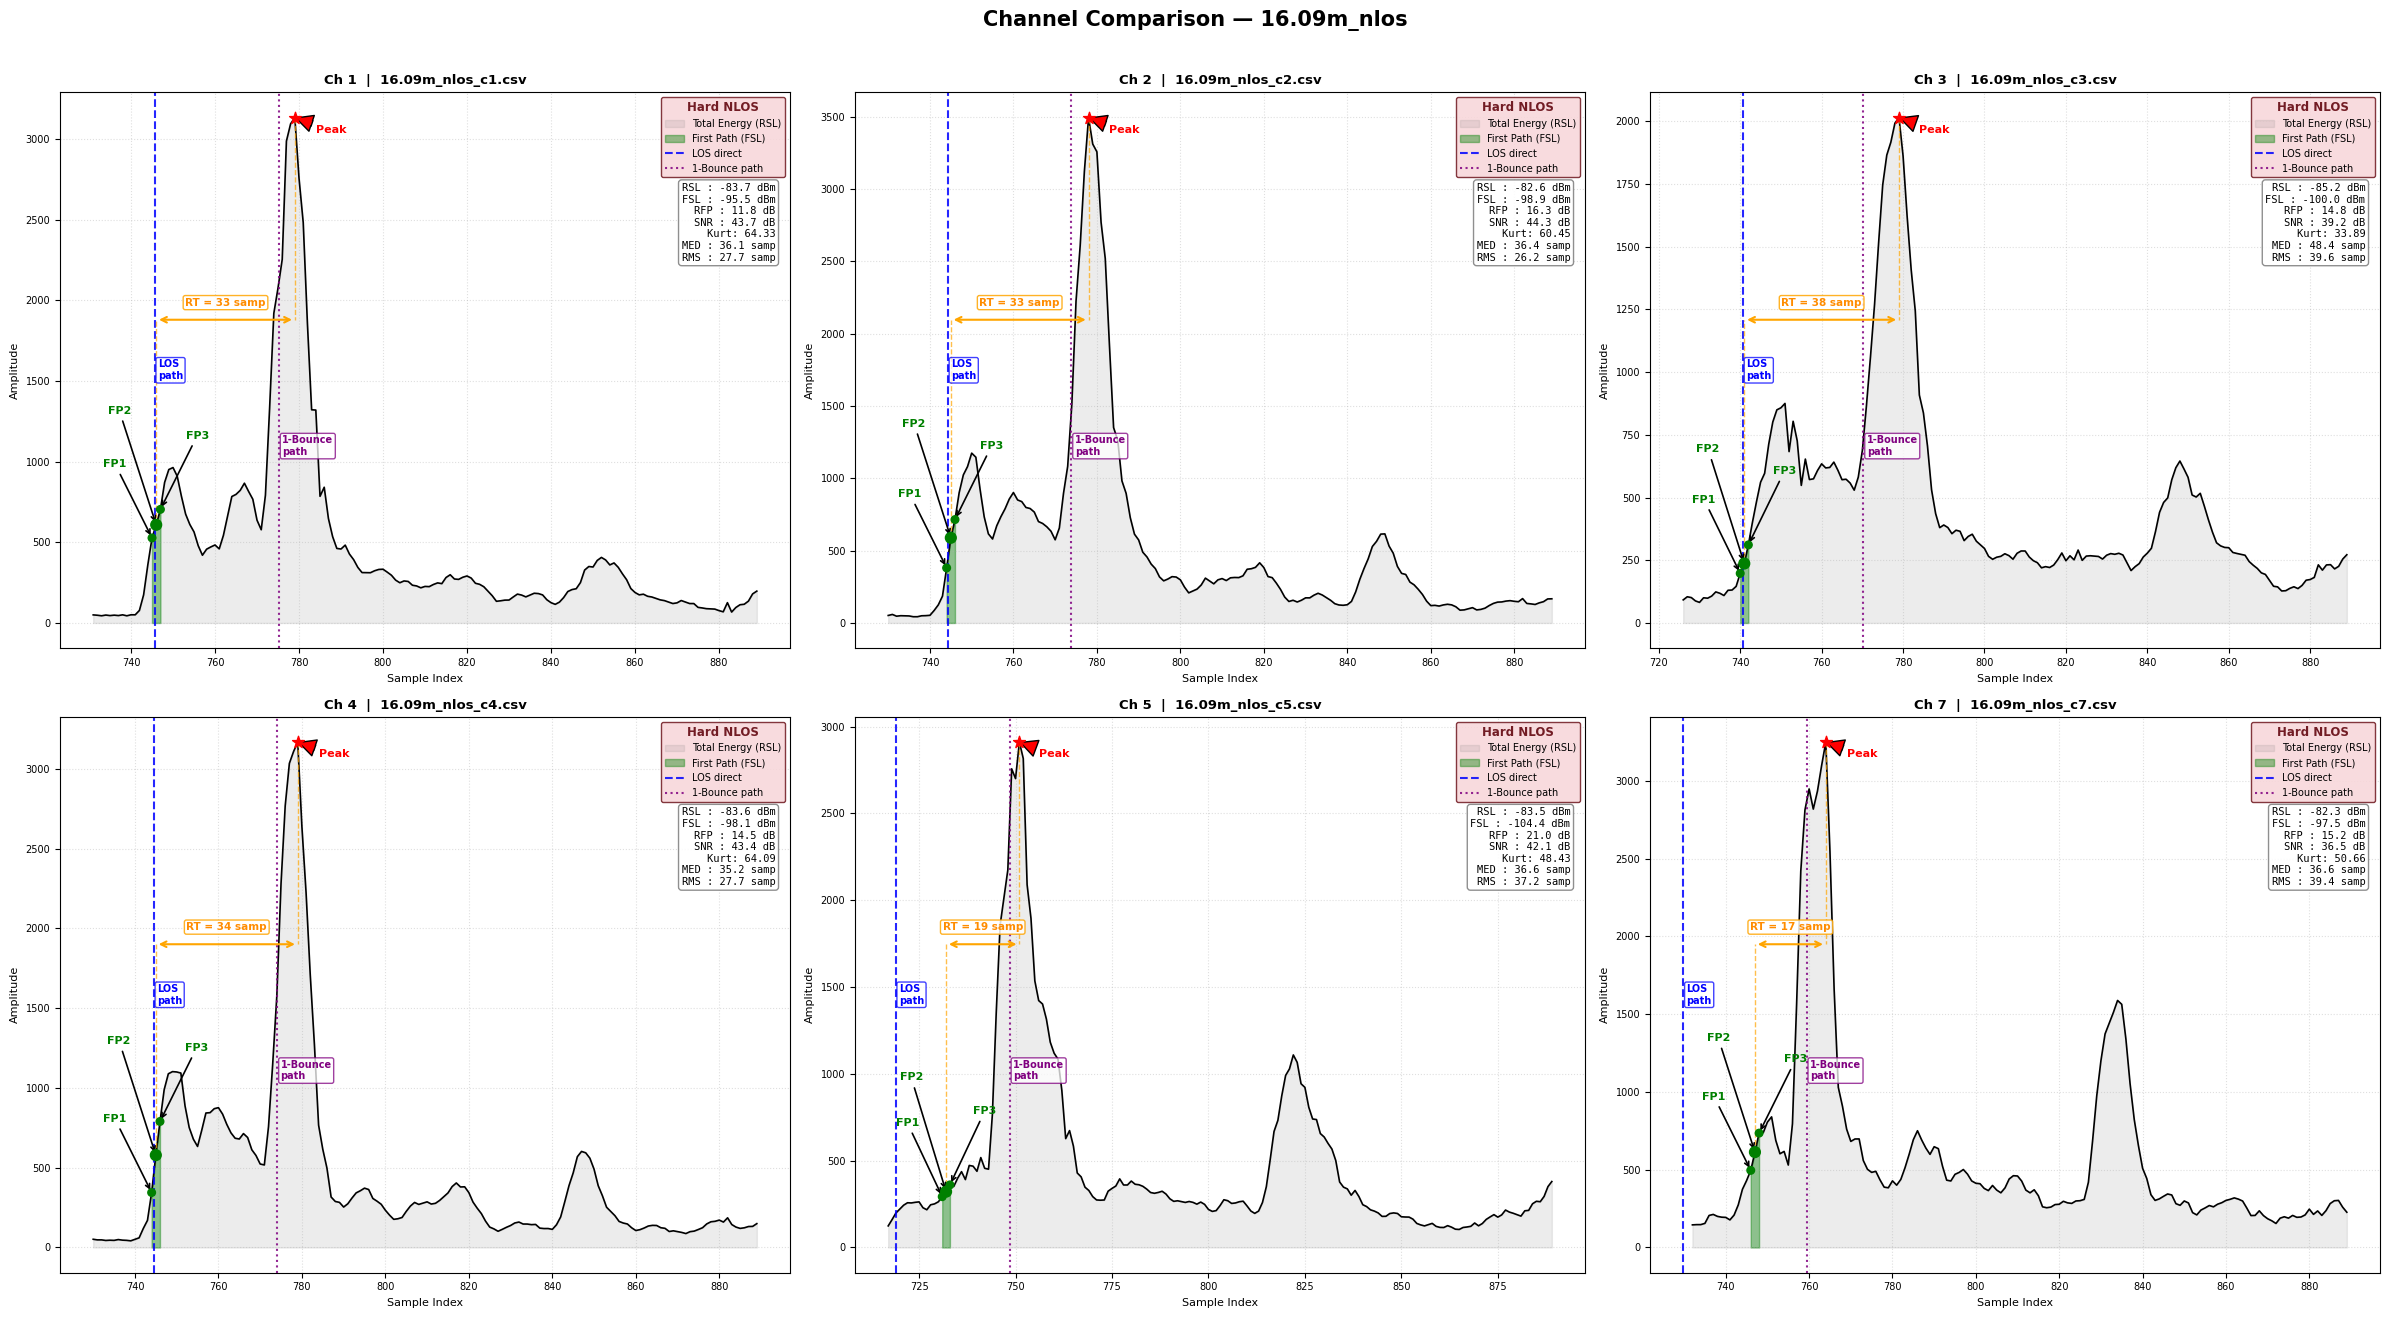

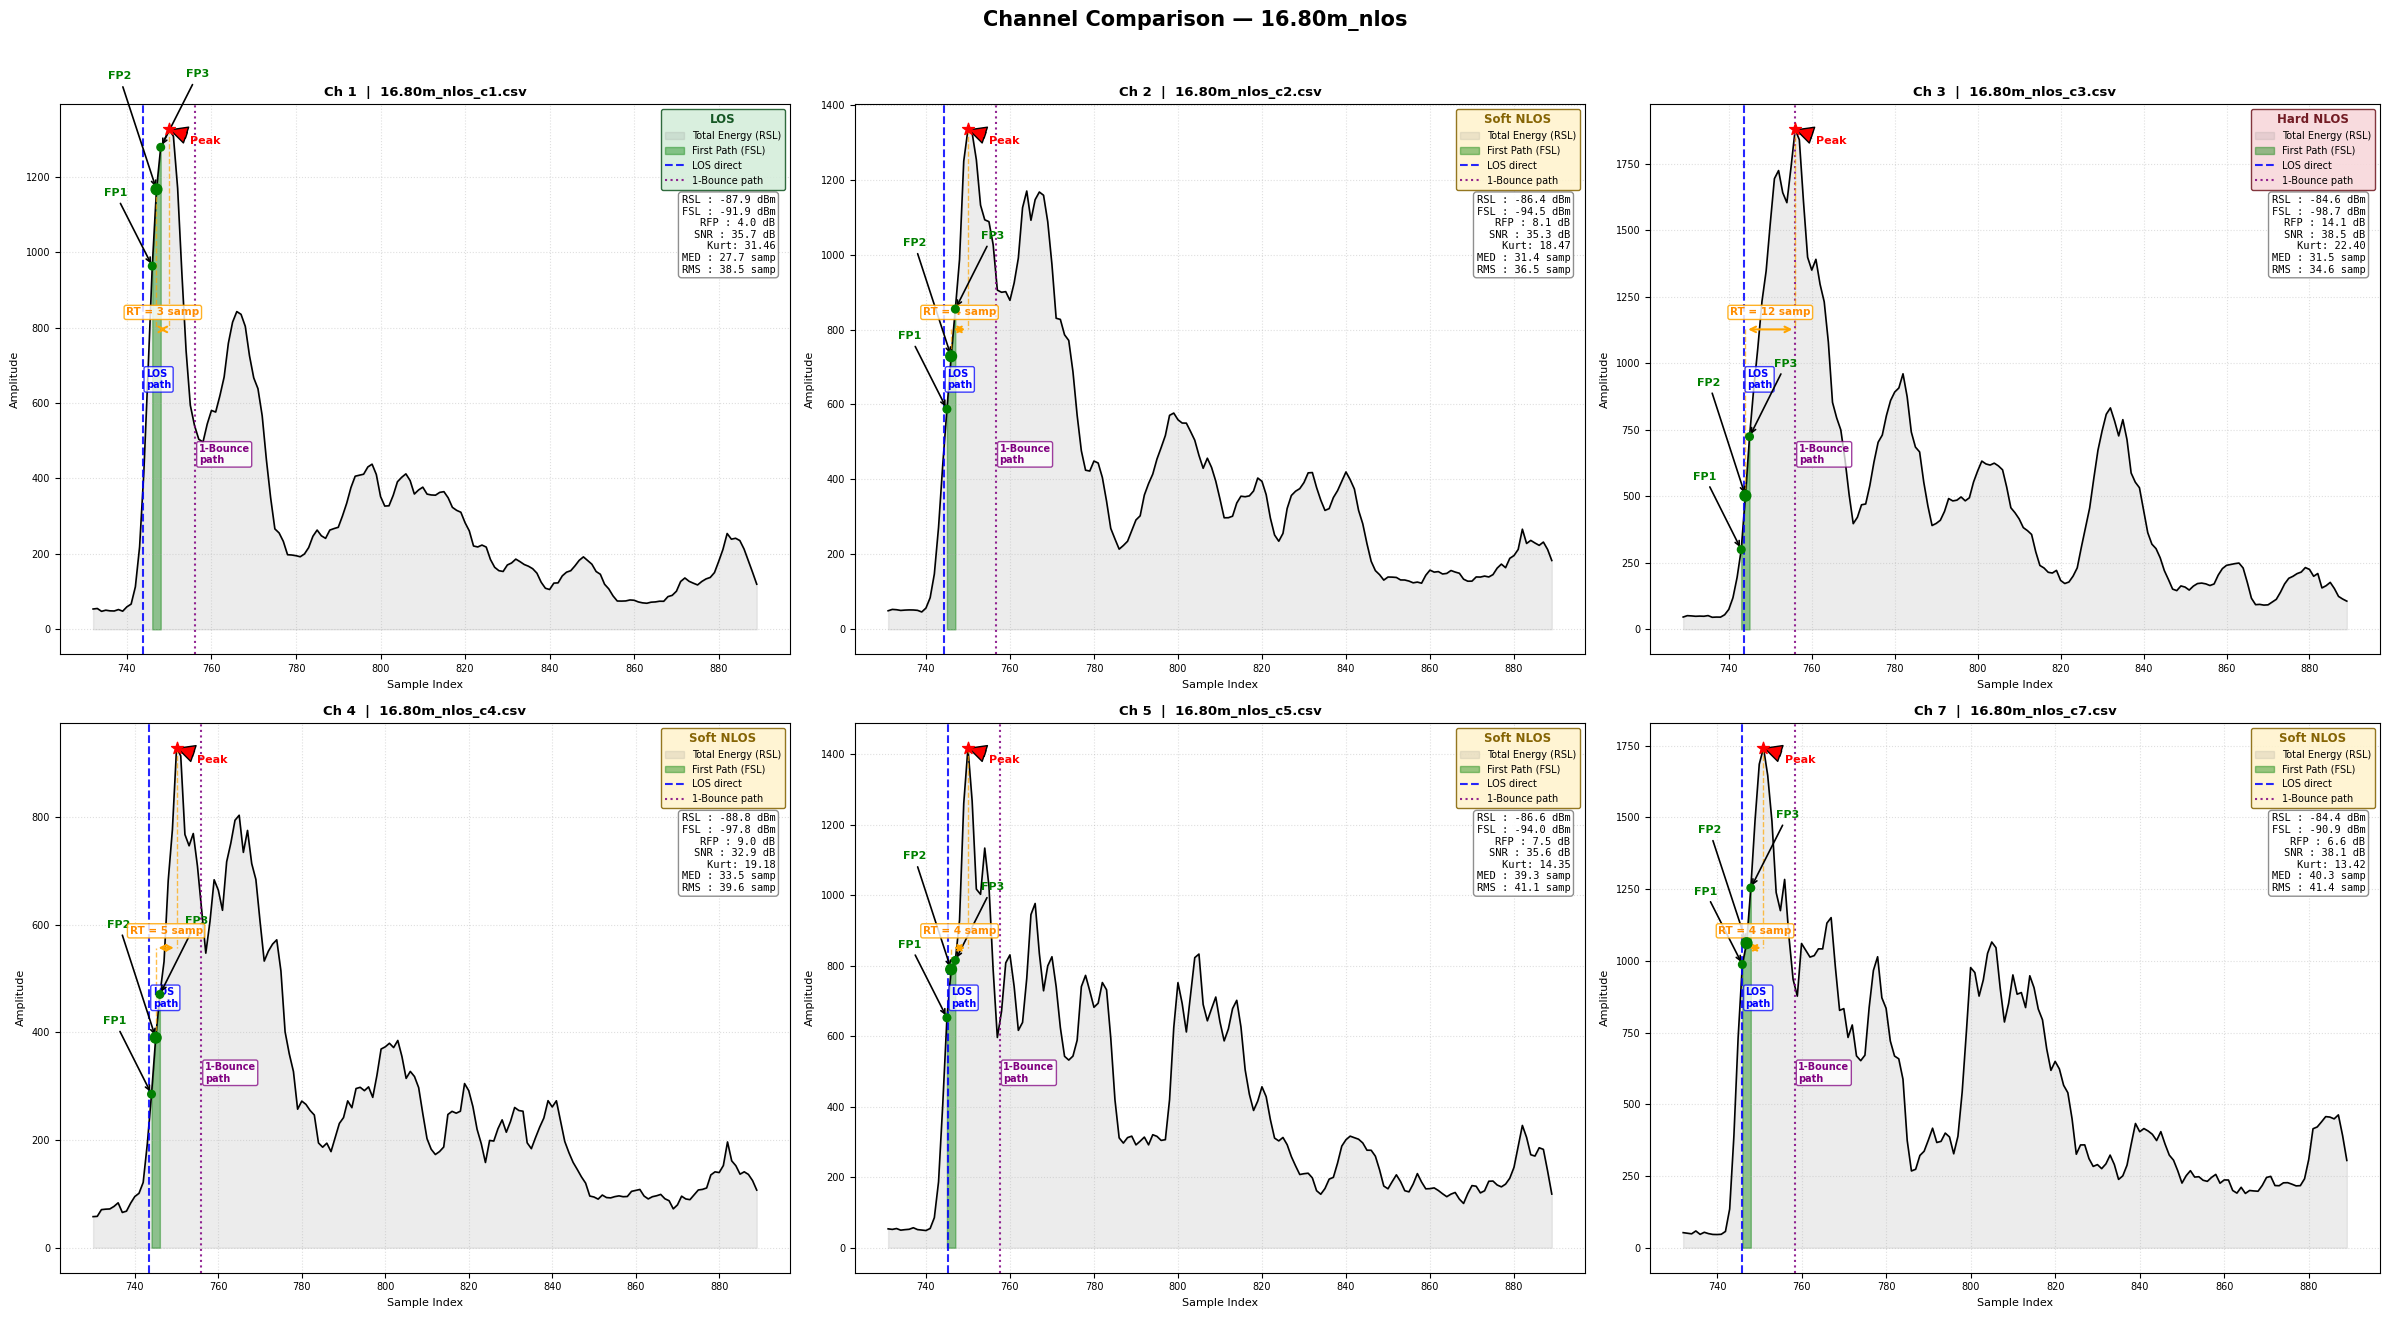

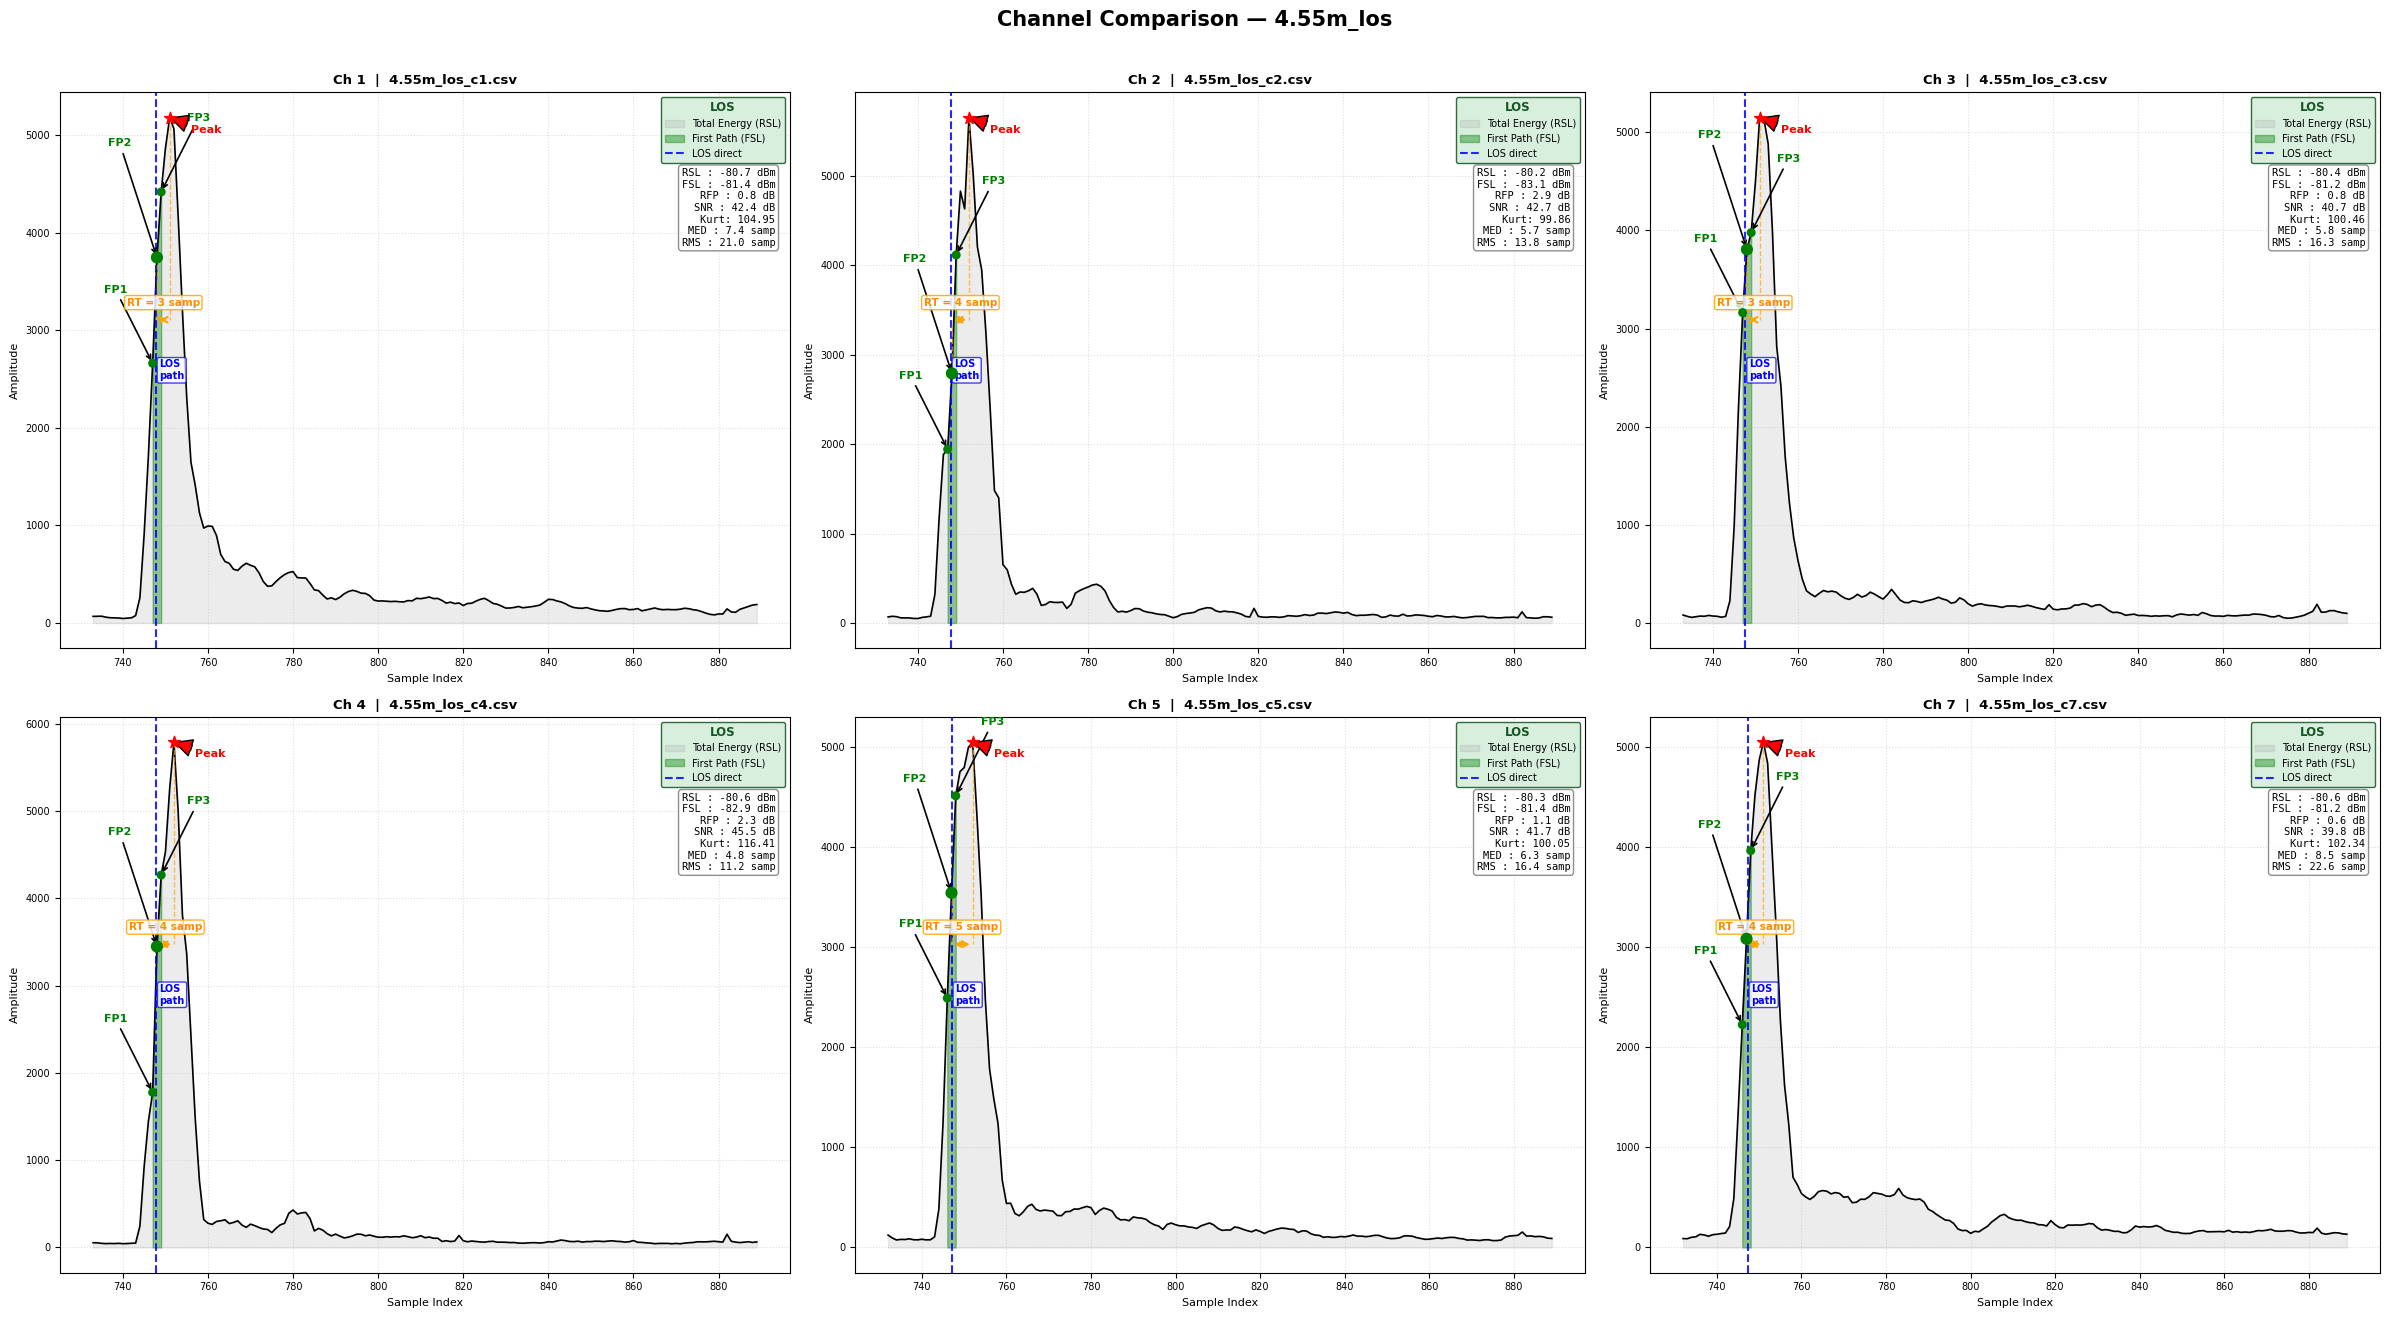

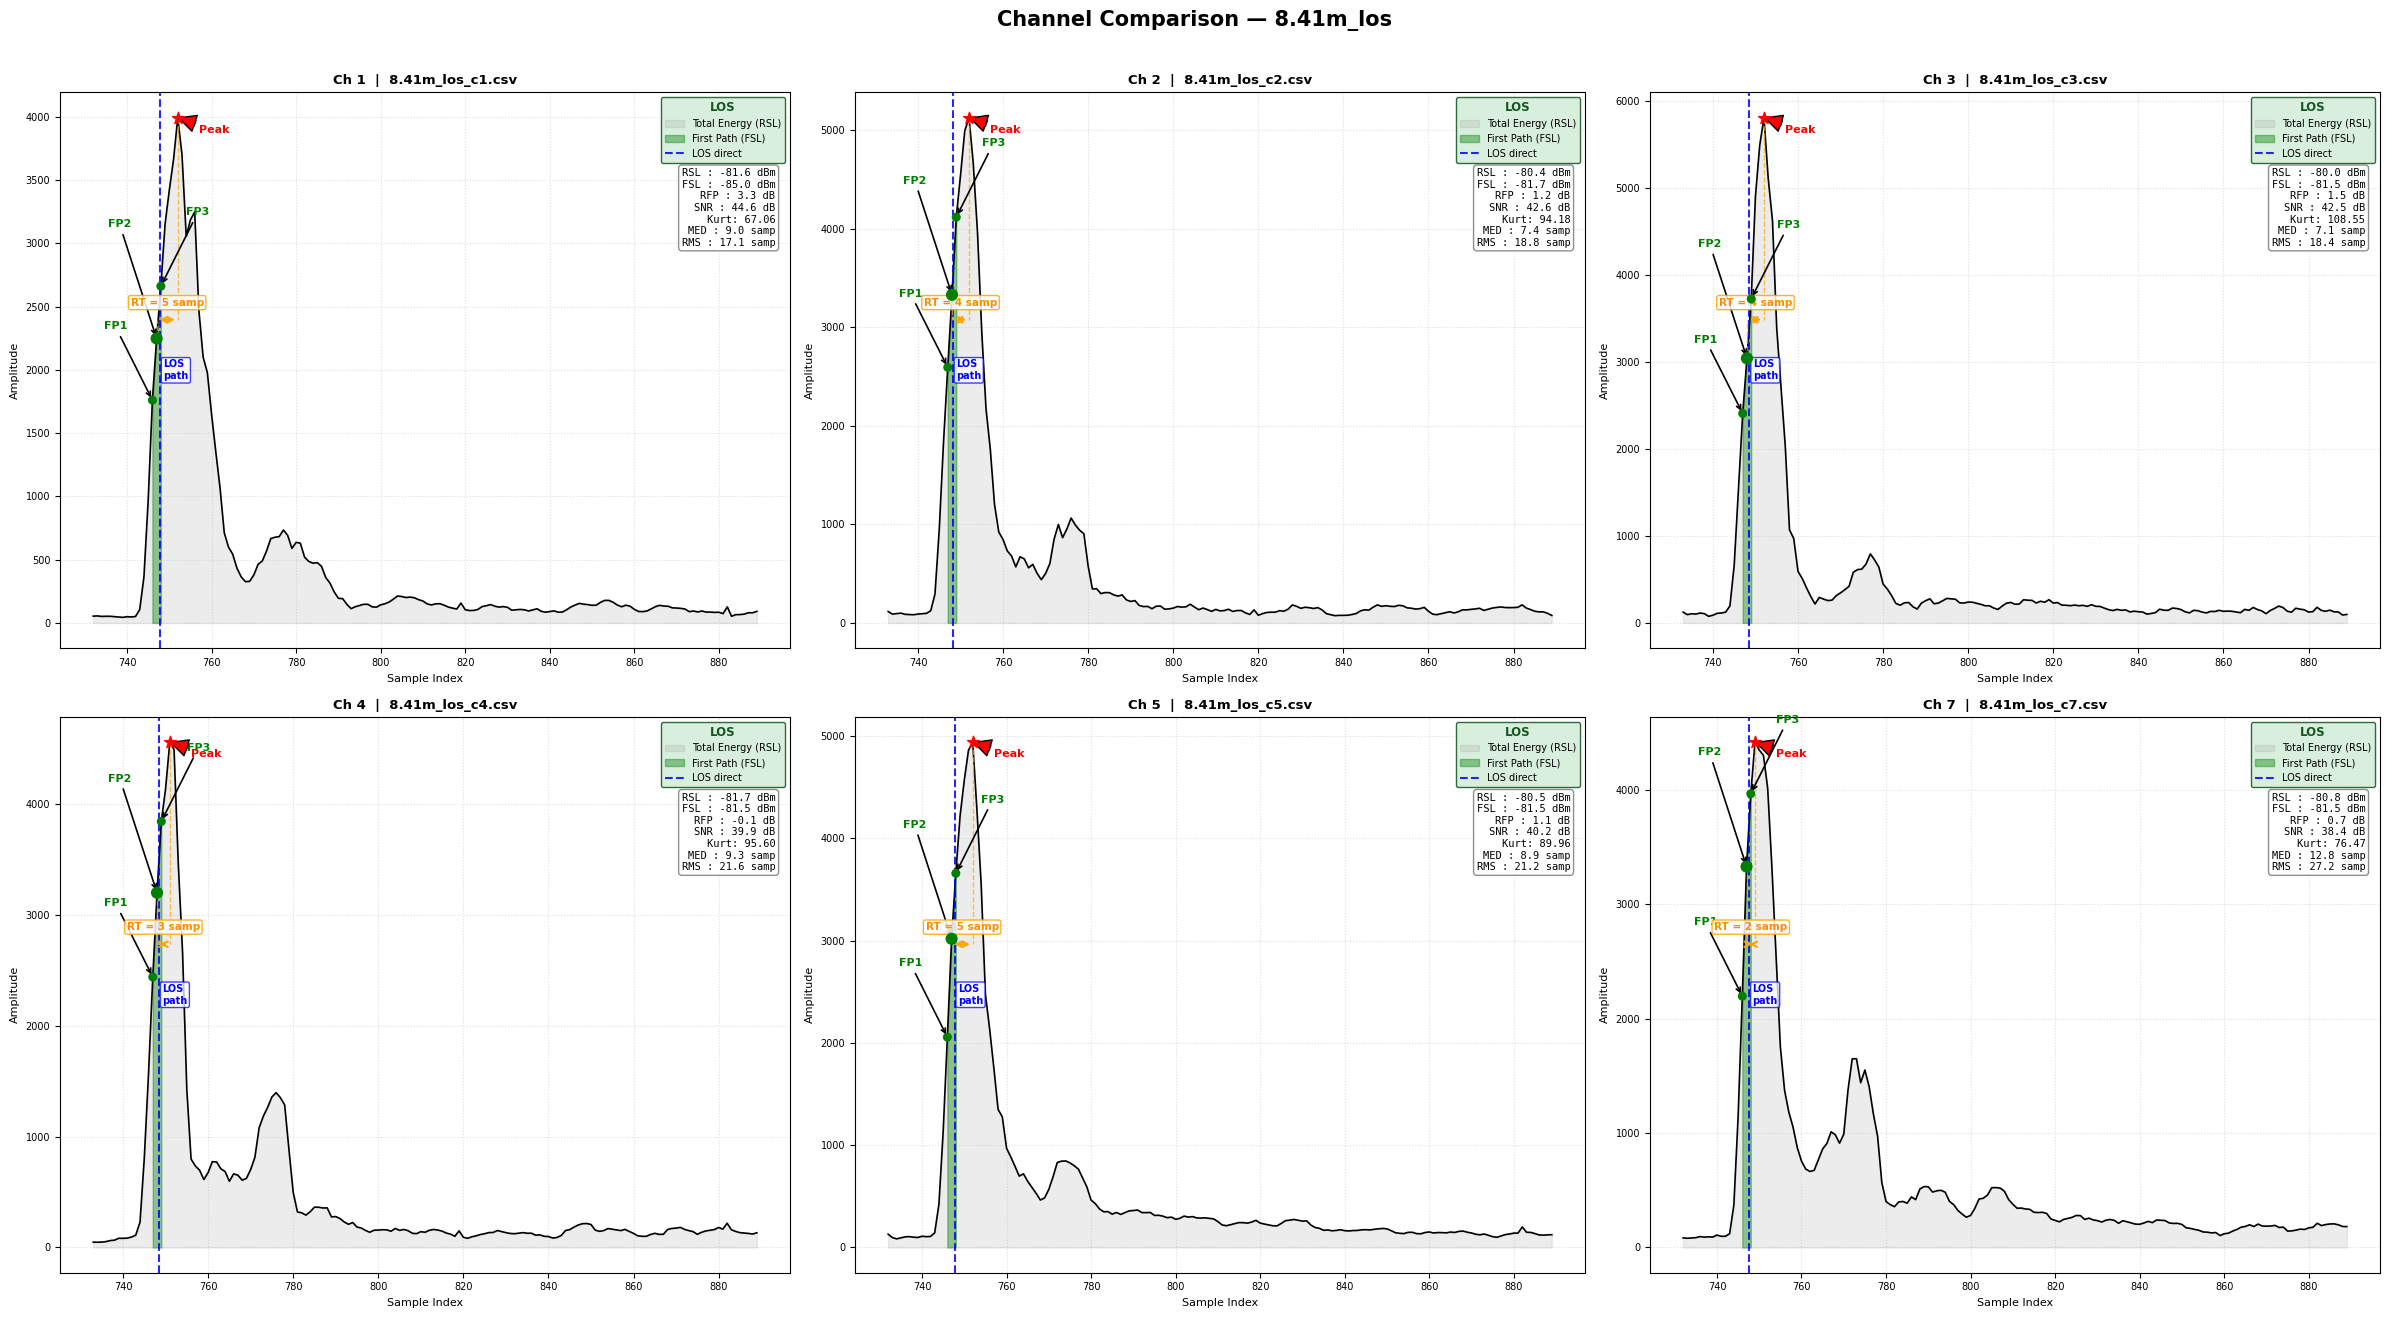

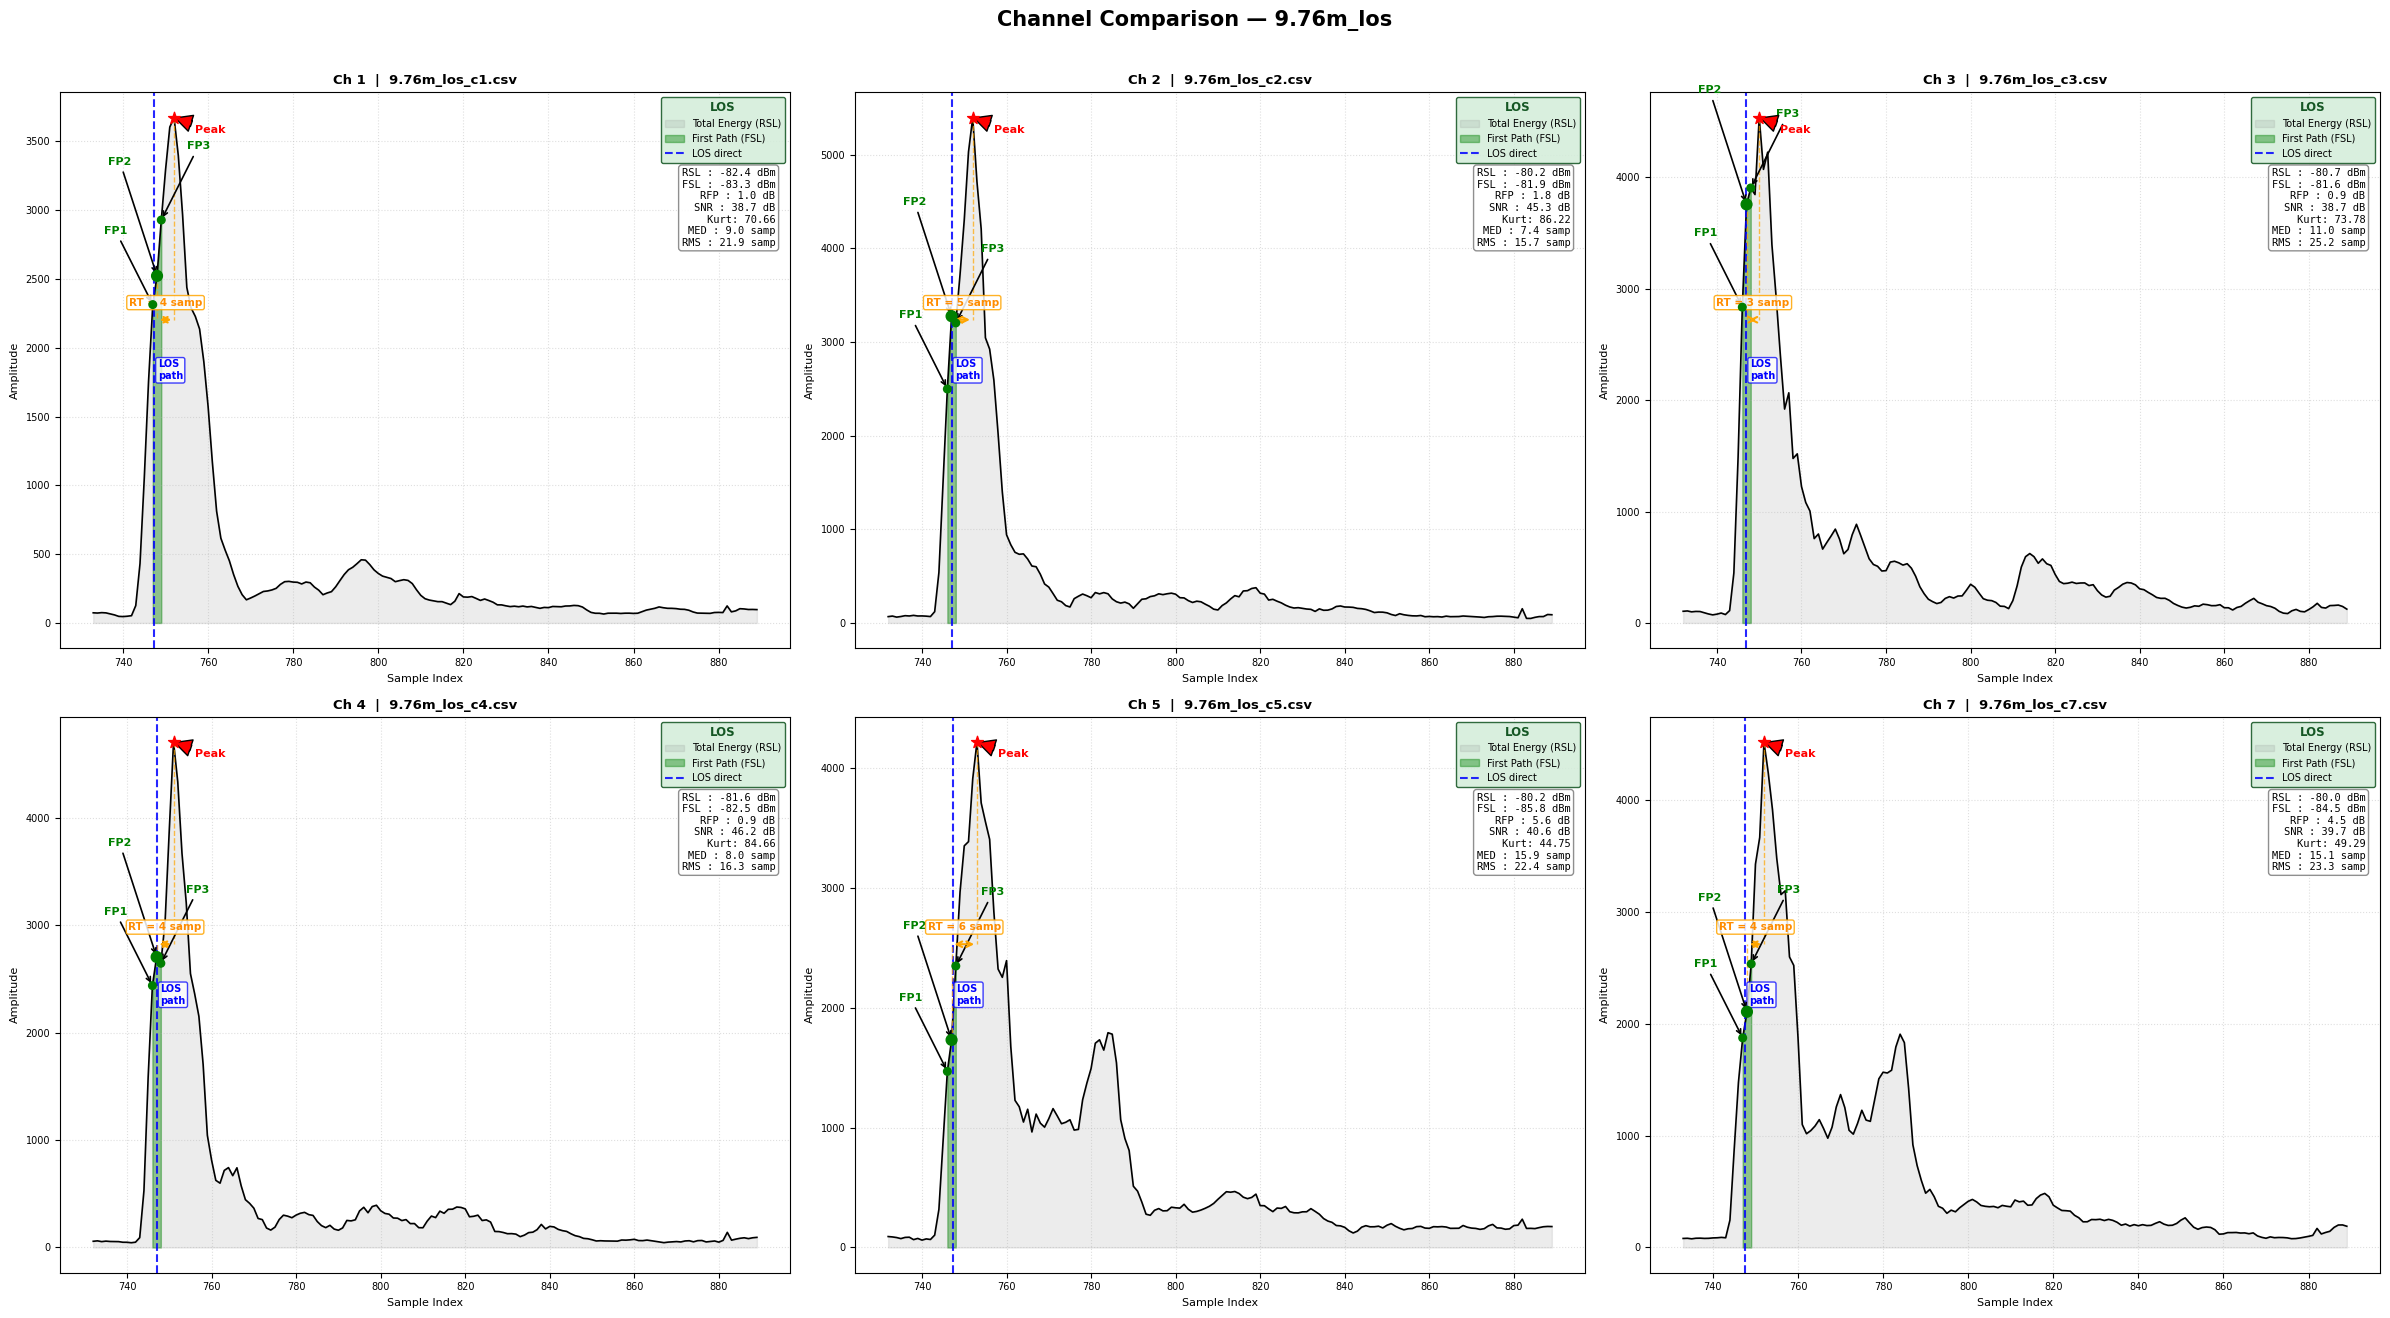

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.stats import kurtosis
import os
import glob
import re

# ==========================================
# GROUND-TRUTH LOOKUP
# NLOS files: prefix = d_bounce; d_direct computed geometrically from floor plan
# LOS  files: prefix = d_direct; no bounce
# ==========================================
NLOS_GT = {
    '12.79m_nlos': {'d_direct':  8.81887, 'd_bounce': 12.79},
    '16.09m_nlos': {'d_direct': 7.20139, 'd_bounce': 16.09},
    '16.80m_nlos': {'d_direct': 13.05986, 'd_bounce': 16.80},
}
METERS_PER_INDEX = 0.3002  # c × 1.0016 ns

def get_ground_truth(scenario_name):
    """Return (d_direct, d_bounce_or_None) for a scenario."""
    if scenario_name in NLOS_GT:
        gt = NLOS_GT[scenario_name]
        return gt['d_direct'], gt['d_bounce']
    m = re.match(r'^([\d.]+)m_los', scenario_name)
    if m:
        return float(m.group(1)), None
    return None, None

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def analyze_hardware_dataset(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None 

        raw_waves = df[cir_cols].values 
        avg_wave = np.mean(raw_waves, axis=0)
        
        A = 121.74 
        if 'RXPACC' in df.columns: N = df['RXPACC'].mean()
        elif 'RXP_ACC' in df.columns: N = df['RXP_ACC'].mean()
        else: N = 128.0 

        raw_sum_squares = np.sum(avg_wave**2)
        if 'CIR_PWR' in df.columns: C = df['CIR_PWR'].mean()
        else: C = raw_sum_squares / (2**17) 
        safe_C = max(C, 1e-9)
        RSL = 10 * np.log10( (safe_C * (2**17)) / (N**2) ) - A

        # Float FP index (for path labeling formula)
        fp_idx_float = df['FP_INDEX'].mean() / 64.0
        hw_fp_idx    = int(fp_idx_float)
        idx_f1 = max(0, hw_fp_idx - 1)
        idx_f2 = hw_fp_idx
        idx_f3 = min(len(avg_wave)-1, hw_fp_idx + 1)
        
        plot_F1 = avg_wave[idx_f1]
        plot_F2 = avg_wave[idx_f2]
        plot_F3 = avg_wave[idx_f3]
        
        if 'FP_AMPL1' in df.columns:
            math_F1, math_F2, math_F3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            math_F1, math_F2, math_F3 = plot_F1, plot_F2, plot_F3

        F_sum = (math_F1**2) + (math_F2**2) + (math_F3**2)
        safe_F = max(F_sum, 1e-9)
        FSL = 10 * np.log10( safe_F / (N**2) ) - A

        if 'STD_NOISE' in df.columns: std_noise = df['STD_NOISE'].mean()
        else: std_noise = np.std(avg_wave[0:30])
        max_amp = np.max(avg_wave)
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))

        kurt_val = kurtosis(avg_wave)
        fp_energy_raw = math_F1**2 + math_F2**2 + math_F3**2
        total_energy_raw = np.sum(avg_wave**2)
        power_ratio = fp_energy_raw / max(total_energy_raw, 1e-9)
        
        pdp = avg_wave[hw_fp_idx:]**2
        times = np.arange(len(pdp))
        total_pdp_pwr = np.sum(pdp) + 1e-9
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))
        
        RFP = RSL - FSL
        if RFP < 6.0: condition = "LOS"
        elif RFP <= 10.0: condition = "Soft NLOS"
        else: condition = "Hard NLOS"
        
        peak_idx = np.argmax(avg_wave)
        rise_time = peak_idx - hw_fp_idx

        # Mean reported distance (needed for FP-anchored path formula)
        mean_distance = df['Distance'].mean() if 'Distance' in df.columns else None

        return {
            "Filename": os.path.basename(filepath),
            "Avg_Wave": avg_wave,
            "HW_FP_Index": hw_fp_idx,
            "FP_Idx_Float": fp_idx_float,
            "Mean_Distance": mean_distance,
            "Indices": (idx_f1, idx_f2, idx_f3, peak_idx),
            "Plot_Amps": (plot_F1, plot_F2, plot_F3),
            "Max_Amp": max_amp,
            "RSL_dBm": RSL,
            "FSL_dBm": FSL,
            "RFP_Metric": RFP,
            "SNR_dB": SNR,
            "Kurtosis": kurt_val,
            "Power_Ratio": power_ratio,
            "Total_Energy": total_energy_raw,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Condition": condition
        }
    except Exception as e: return None

# ==========================================
# 2. PLOTTER — 2×3 Grid (all 6 channels per scenario)
# ==========================================
def plot_final_standard_labels(scenario_prefix):
    files = sorted(glob.glob(f"{scenario_prefix}_c*.csv"))
    if not files: return

    all_data = [d for d in (analyze_hardware_dataset(f) for f in files) if d]
    if not all_data: return

    scenario_name = os.path.basename(scenario_prefix)
    d_direct, d_bounce = get_ground_truth(scenario_name)

    fig, axes = plt.subplots(2, 3, figsize=(24, 13))
    fig.suptitle(f"Channel Comparison — {scenario_name}", fontsize=15, fontweight='bold', y=1.01)
    axes = axes.flatten()

    subplot_refs = []  # (ax, legend, metrics_str)

    for i, data in enumerate(all_data):
        ax = axes[i]
        avg_wave = data['Avg_Wave']
        hw_fp    = data['HW_FP_Index']
        fp_float = data['FP_Idx_Float']
        mean_dist = data['Mean_Distance']
        idx_f1, idx_f2, idx_f3, peak_idx = data['Indices']
        f1, f2, f3 = data['Plot_Amps']
        max_amp  = data['Max_Amp']

        start  = max(0, hw_fp - 15)
        end    = min(len(avg_wave), 890)
        x_zoom = np.arange(start, end)
        y_zoom = avg_wave[start:end]

        # --- WAVEFORM ---
        ax.fill_between(x_zoom, 0, y_zoom, color='gray', alpha=0.15, label='Total Energy (RSL)')
        ax.fill_between([idx_f1, idx_f2, idx_f3], 0, [f1, f2, f3], color='green', alpha=0.4, label='First Path (FSL)')
        ax.plot(x_zoom, y_zoom, color='black', linewidth=1.2)

        # --- GROUND-TRUTH PATH MARKERS ---
        if d_direct is not None and mean_dist is not None:
            los_idx = fp_float + (d_direct - mean_dist) / METERS_PER_INDEX
            ax.axvline(los_idx, color='blue', linestyle='--', lw=1.5, alpha=0.85, label='LOS direct')
            ax.text(los_idx + 0.8, max_amp * 0.50, 'LOS\npath',
                    color='blue', fontsize=7, fontweight='bold', va='center',
                    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.75,
                              boxstyle='round,pad=0.2'))

        if d_bounce is not None and mean_dist is not None:
            bounce_idx = fp_float + (d_bounce - mean_dist) / METERS_PER_INDEX
            ax.axvline(bounce_idx, color='purple', linestyle=':', lw=1.5, alpha=0.85, label='1-Bounce path')
            ax.text(bounce_idx + 0.8, max_amp * 0.35, '1-Bounce\npath',
                    color='purple', fontsize=7, fontweight='bold', va='center',
                    bbox=dict(facecolor='white', edgecolor='purple', alpha=0.75,
                              boxstyle='round,pad=0.2'))

        # --- FP1 / FP2 / FP3 ---
        ax.scatter([idx_f1, idx_f2, idx_f3], [f1, f2, f3], color='green', s=[30, 60, 30], zorder=5)
        ax.annotate('FP1', xy=(idx_f1, f1),
                    xytext=(idx_f1 - 6, f1 + max_amp * 0.14),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.2),
                    fontsize=8, color='green', fontweight='bold', ha='right')
        ax.annotate('FP2', xy=(idx_f2, f2),
                    xytext=(idx_f2 - 6, f2 + max_amp * 0.22),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.2),
                    fontsize=8, color='green', fontweight='bold', ha='right')
        ax.annotate('FP3', xy=(idx_f3, f3),
                    xytext=(idx_f3 + 6, f3 + max_amp * 0.14),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.2),
                    fontsize=8, color='green', fontweight='bold', ha='left')

        # --- MAX PEAK ---
        ax.scatter(peak_idx, max_amp, color='red', s=80, marker='*', zorder=5)
        ax.annotate('Peak', xy=(peak_idx, max_amp),
                    xytext=(peak_idx + 5, max_amp * 0.97),
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    fontsize=8, color='red', fontweight='bold')

        # --- RISE-TIME BRACKET ---
        dim_y = max_amp * 0.60
        ax.plot([hw_fp, hw_fp],       [f2, dim_y],     color='orange', linestyle='--', alpha=0.7, lw=1)
        ax.plot([peak_idx, peak_idx], [max_amp, dim_y], color='orange', linestyle='--', alpha=0.7, lw=1)
        ax.annotate('', xy=(hw_fp, dim_y), xytext=(peak_idx, dim_y),
                    arrowprops=dict(arrowstyle='<->', color='orange', lw=1.5))
        mid_x = (hw_fp + peak_idx) / 2
        ax.text(mid_x, dim_y * 1.04, f"RT = {data['Rise_Time']} samp",
                color='darkorange', fontsize=7.5, ha='center', va='bottom', fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2', alpha=0.85))

        # --- CONDITION LEGEND (top-right) ---
        cond     = data['Condition']
        badge_fc = '#d4edda' if cond == 'LOS' else ('#fff3cd' if 'Soft' in cond else '#f8d7da')
        badge_ec = '#155724' if cond == 'LOS' else ('#856404' if 'Soft' in cond else '#721c24')

        leg = ax.legend(fontsize=7, loc='upper right', framealpha=0.88,
                        title=cond, title_fontsize=8.5,
                        facecolor=badge_fc, edgecolor=badge_ec)
        leg.get_title().set_color(badge_ec)
        leg.get_title().set_fontweight('bold')

        ch_match = re.search(r'_c(\d+)\.csv$', data['Filename'], re.IGNORECASE)
        ch_label = f"Ch {ch_match.group(1)}" if ch_match else data['Filename']
        ax.set_title(f"{ch_label}  |  {data['Filename']}", fontsize=9.5, fontweight='bold')
        ax.set_xlabel("Sample Index", fontsize=8)
        ax.set_ylabel("Amplitude",    fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, linestyle=':', alpha=0.4)

        metrics_str = (
            f"RSL : {data['RSL_dBm']:.1f} dBm\n"
            f"FSL : {data['FSL_dBm']:.1f} dBm\n"
            f"RFP : {data['RFP_Metric']:.1f} dB\n"
            f"SNR : {data['SNR_dB']:.1f} dB\n"
            f"Kurt: {data['Kurtosis']:.2f}\n"
            f"MED : {data['Mean_Excess_Delay']:.1f} samp\n"
            f"RMS : {data['RMS_Delay_Spread']:.1f} samp"
        )
        subplot_refs.append((ax, leg, metrics_str))

    for j in range(len(all_data), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

    # --- PASS 2: place metrics boxes flush below each legend ---
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    for ax, leg, metrics_str in subplot_refs:
        leg_bb = leg.get_window_extent(renderer=renderer)
        ax_bb  = ax.get_window_extent(renderer=renderer)
        leg_bottom_frac = (leg_bb.y0 - ax_bb.y0) / ax_bb.height
        ax.text(0.98, leg_bottom_frac - 0.01, metrics_str, transform=ax.transAxes,
                fontsize=7.5, family='monospace', va='top', ha='right',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.88, boxstyle='round,pad=0.3'))

    plt.show()

# Run — search in dataset/channels/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in scenarios:
    plot_final_standard_labels(s)


### 2.2 Commentary — Individual Waveform Analysis

---

#### Physics Background & Formula Derivation

**UWB CIR Accumulator**

The DW1000 records 1016 time-domain samples of the received impulse response. Each sample corresponds to one chip period of ~1.0016 ns. At the speed of light (c = 299,792,458 m/s), each CIR index spans:

```
distance_per_index = c × 1.0016 × 10⁻⁹ ≈ 0.3002 m/index
```

**FP_INDEX Register**

The hardware provides `FP_INDEX`, a 16-bit register where:
- Upper 10 bits → integer CIR sample index
- Lower 6 bits → fractional part (1/64 resolution)

Dividing by 64.0 converts it to the floating-point CIR array index where the leading edge was detected:

```
fp_idx = FP_INDEX / 64.0   →   the CIR index corresponding to the reported Distance
```

**Time-of-Flight Offset Formula**

The hardware anchor (`fp_idx`) corresponds to the reported `Distance`. If the true physical path is longer than what the hardware reports, the signal arrived **later**, so its CIR position sits at a **higher index**. The offset is:

```
target_idx = fp_idx + (true_distance − Distance) / 0.3002

  LOS:  true_distance ≈ Distance   →  target ≈ fp_idx          (validated by calibration)
  NLOS: true_distance = d_bounce > Distance  →  target > fp_idx (bounce arrives later)
```

**Why FP-relative and NOT absolute?**

The DW1000 dynamically shifts its CIR receive window so the leading edge always lands near index ~748, regardless of the actual physical distance. An absolute formula (`calib_offset + d/0.3002`) would misplace markers by 20–40 indices, because the window offset shifts with each measurement. The FP-anchored approach is correct because:
- `FP_INDEX/64` and `Distance` always shift together — their difference cancels the window offset
- For LOS: `d_direct ≈ Distance` → `los_path_idx ≈ fp_idx` ✓
- For NLOS: `d_bounce > Distance` → `bounce_path_idx > fp_idx` ✓

**Ground-Truth Marker Formulas (applied in plots below)**

```
fp_idx          = FP_INDEX / 64.0
d_direct_idx    = fp_idx + (d_direct  − Distance) / 0.3002   [blue  dashed]
bounce_path_idx = fp_idx + (d_bounce  − Distance) / 0.3002   [purple dotted — NLOS only]
```

Where `d_direct` is the laser-measured reference distance:
- **LOS scenarios** — `d_direct` = true TX→RX straight-line distance → blue line lands near FP2 (validates calibration)
- **NLOS scenarios** — `d_direct` = **true TX→RX straight-line distance**, computed geometrically from the floor plan (Pythagorean theorem from measured anchor coordinates)

The gap between the two markers = `(d_bounce − d_direct) / 0.3002` representing the extra path delay of the bounce route relative to the true straight-line path.

**True NLOS Ranging Error vs d_bounce − d_direct**

For NLOS scenarios, the true ranging error is `UWB reported Distance − d_direct`. When hardware locks onto the bounce, Distance ≈ d_bounce, so ranging error ≈ d_bounce − d_direct. Note: TX→reflector leg (= d_bounce − reflector→RX) is a separate geometric quantity ≠ d_bounce − d_direct. Example for the 16.09m scenario:

| | Value |
|---|---|
| UWB reported Distance | ~16.09 m (FP locked onto bounce) |
| True TX→RX (Pythagorean theorem from floor plan) | ~7.20 m |
| **True NLOS ranging error** | **16.09 − 7.20 = 8.89 m** |
| Path difference (d_bounce − d_direct) | **8.89 m** ≈ ranging error when FP locks onto bounce |
| TX→reflector leg (d_bounce − reflector→RX) | 5.32 m ← geometric property, ≠ d_bounce − d_direct |

**FP_AMPL1/2/3 Validation**

The DW1000 reports three amplitude samples (F1, F2, F3) at/around the hardware-detected first path. If `|fp_idx − d_direct_idx|` is small, F1/F2/F3 faithfully represent the first-arriving signal. If the offset is large, the hardware was fooled by the bounce reflection and FP does not correspond to the true first path.

---

#### Waveform Observations by Scenario

Each scenario is plotted as a 2×3 grid (one subplot per channel, Ch1–Ch7). All waveforms are the **mean of 100 captures** per channel. Three markers are overlaid on every subplot:
- **Green fill / FP1–FP2–FP3** — hardware first-path detection window (DW1000 FP_INDEX)
- **Blue dashed** — `fp_idx + (d_direct − Distance) / 0.3002` (laser-measured reference distance)
- **Purple dotted** — `fp_idx + (d_bounce − Distance) / 0.3002` (full 1-bounce path, NLOS only)

---

#### LOS Scenarios

- The CIR exhibits a **sharp, symmetric leading pulse** with most energy concentrated at FP1–FP3. The green FSL shading covers the dominant peak, confirming the hardware correctly locked onto the first arriving signal.
- The **blue line coincides closely with FP2** — since `d_direct ≈ Distance` for LOS, the formula gives `d_direct_idx ≈ fp_idx`, validating both the formula and the antenna delay calibration.
- **Rise time is short** (typically 1–3 samples) and the waveform tail decays rapidly, indicating minimal multipath energy. Kurtosis is high, confirming a strongly impulsive signal dominated by a single wavefront.
- **Channel-to-channel consistency is high** — all 6 channels show nearly identical pulse position and shape, differing only in amplitude due to per-channel centre frequency and bandwidth differences (C5/C7 at 6.5 GHz attenuate more with distance than C1–C3).

---

#### NLOS Scenario — 12.79m (TX→reflector = 5.00m, reflector→RX = 7.79m, d_direct = 8.81887m)

- The **purple 1-bounce marker is clearly shifted right** from the blue line by ~13.2 samples ((12.79 − 8.819) / 0.3002 = (d_bounce − d_direct) / 0.3002), marking where the dominant bounce energy actually arrives.
- RFP > 6 dB in most channels, correctly triggering Soft or Hard NLOS classification. SNR is lower and kurtosis is reduced compared to LOS due to energy spread across multipath components in the waveform tail.
- **FP2 aligns with or near the purple marker**, confirming the hardware locked onto the bounce as "first path" — causing a large positive ranging bias.

---

#### NLOS Scenario — 16.09m (TX→reflector = 5.32m, reflector→RX = 10.77m, d_direct = 7.20139m)

- The bounce marker is positioned ~29.6 samples ((16.09 − 7.201) / 0.3002 = (d_bounce − d_direct) / 0.3002) to the right of the blue line. The longer reflector→RX leg introduces more free-space propagation loss, lowering RSL and FSL relative to the 12.79m scenario.
- MED and RMS Delay Spread are noticeably elevated above LOS, reflecting secondary reflections off basement walls and the glass door — key discriminating features for the LNN classifier.
- Channels with wider bandwidth (C4, C7) show better time resolution, making the bounce pulse more distinct.

---

#### NLOS Scenario — 16.80m (TX→reflector = 2.80m, reflector→RX = 14.00m, d_direct = 13.05986m)

- With d_direct = 13.05986m confirmed (= √(11.60² + 6.00²), floor plan geometry), the bounce marker sits **~12.5 samples** ((16.80 − 13.06) / 0.3002) to the right of the LOS direct marker — the **smallest path-difference separation** of the three NLOS scenarios.
- In some channels, the bounce pulse partially overlaps with the blue reference position, making this the **most challenging scenario** for the RFP threshold classifier.
- Despite the small path separation, RFP > 6 dB in most channels due to the long waveform tail from the 14.00m reflector→RX leg. Some channels show FP2 positioned between the two markers, indicating the hardware partially detected an intermediate reflection.

---

#### Cross-Scenario Summary

| Observation | LOS | 12.79m NLOS | 16.09m NLOS | 16.80m NLOS |
|---|---|---|---|---|
| Pulse sharpness | Sharp, impulsive | Broad, diffuse | Broad, diffuse | Moderate |
| Waveform tail | Short decay | Long, complex | Long, complex | Moderate |
| FP alignment | At d_direct | At bounce | At bounce | Near bounce |
| Bounce separation (d_bounce−d_direct)/0.3002 | — | ~13.2 samples | ~29.6 samples | ~12.5 samples |
| Channel consistency | High | Moderate | Moderate | Lower |
| LNN discriminability | Easy | Easy | Easy | Hardest |

The 16.80m NLOS scenario is the most challenging for both the threshold-based RFP classifier and the LNN Stage 1 model — its CIR closely resembles a LOS waveform in shape yet carries a significant ranging bias. This motivates using the **full 1016-sample CIR** as LNN input rather than relying on scalar metrics alone.

---


## 2.3 FP_INDEX Validation — Where Are FP_AMPL1/2/3 Sampling?

The DW1000 reports three amplitude samples — **FP_AMPL1**, **FP_AMPL2**, **FP_AMPL3** — at consecutive CIR indices around its detected first path (`FP_INDEX / 64`). Hardware metrics such as RSL, FSL, and RFP are all derived from these three values.

The critical question is: **does the hardware first-path land at the true LOS arrival, or at a reflected bounce?**

The **FP-to-LOS offset** quantifies this error in CIR samples:

$$\text{fp\_to\_los\_offset} = \frac{\text{FP\_INDEX}}{64} - \text{los\_path\_idx} = \frac{\text{Distance} - d_\text{direct}}{0.3002}$$

| Condition | Offset | Implication for F1/F2/F3 |
|-----------|--------|--------------------------|
| **LOS** | ≈ 0 | Hardware locked onto LOS signal — F1/F2/F3 faithfully represent the direct path |
| **NLOS** | > 0 | Hardware locked onto the bounce — F1/F2/F3 are sampling the reflection, **not** the LOS signal |

This is why threshold classifiers that rely solely on RSL/FSL/RFP fail on clean single-bounce NLOS: the amplitudes they use describe the bounce path, not the blocked direct path.


Loaded 3600 rows, 1016 CIR columns

PER-SCENARIO SUMMARY  —  los_path_idx = FP_INDEX/64 + (d_direct − Distance) / 0.3002
Source Pattern         | Cond  | d_direct | d_bounce |  <los_idx> | <bounce_idx> |  <fp_idx> |  <fp-los> |  <peak>
------------------------------------------------------------------------------------------------------------------------
4.55m_los_c*           | LOS   |     4.55 |      N/A |     747.53 |          N/A
16.09m_nlos_c*         | NLOS  |     7.20 |    16.09 |     737.30 |       766.90 |    743.14 |     +5.85 |   770.2
8.41m_los_c*           | LOS   |     8.41 |      N/A |     748.04 |          N/A
12.79m_nlos_c*         | NLOS  |     8.82 |    12.79 |     734.80 |       748.03 |    744.52 |     +9.72 |   748.8
9.76m_los_c*           | LOS   |     9.76 |      N/A |     747.21 |          N/A
16.80m_nlos_c*         | NLOS  |    13.06 |    16.80 |     744.36 |       756.82 |    746.23 |     +1.87 |   752.6

FP-TO-LOS PROXIMITY  —  how often does HW first-path l

C:\Users\preca\AppData\Local\Temp\ipykernel_13744\3063080647.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


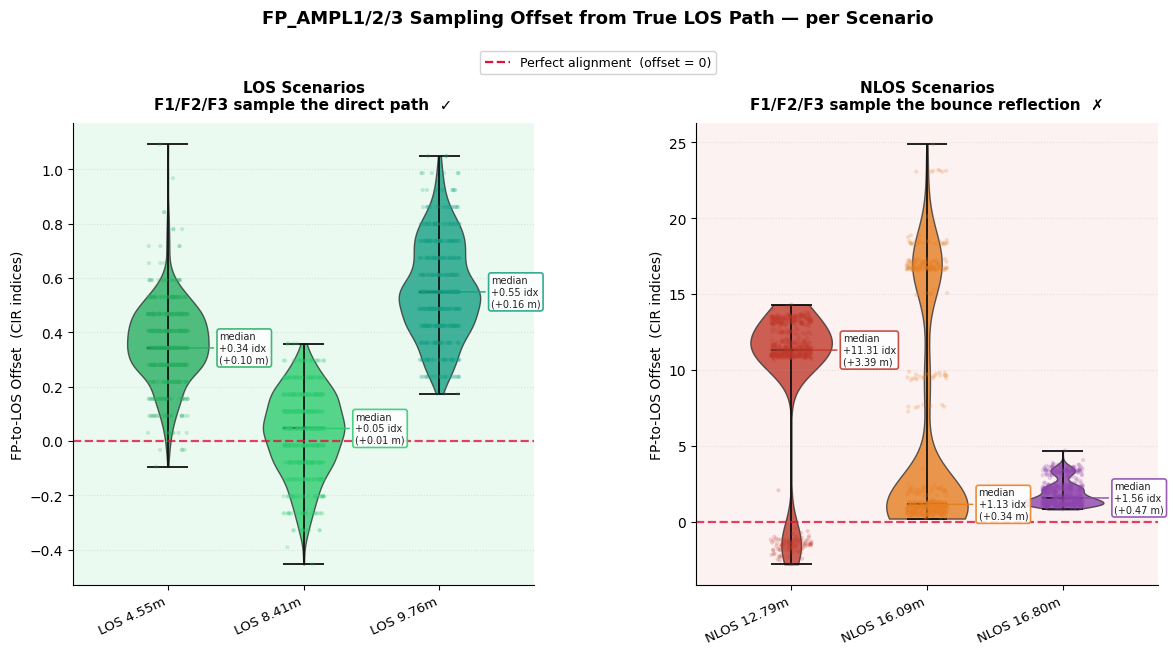


Columns added to df_combined:
  d_direct, d_bounce, fp_idx, los_path_idx, bounce_path_idx,
  fp_to_los_offset, peak_idx, channel, cir_at_los_path


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
import re

DIST_PER_CIR_INDEX = 0.3002  # metres per CIR sample (c × 1.0016 ns)

# Keys = combined-CSV filename prefix (= reflector→RX, laser-measured)
# d_direct = true TX→RX, computed geometrically from floor plan
# 16.80m d_direct = 13.05986m confirmed (√(11.60² + 6.00²), floor plan geometry)
NLOS_GROUND_TRUTH = {
    "12.79":  {"d_direct":  8.81887, "d_bounce": 12.79},
    "16.09": {"d_direct":  7.20139, "d_bounce": 16.09},
    "16.80":    {"d_direct": 13.05986,    "d_bounce": 16.80},
}

# ── Load combined dataset ──────────────────────────────────────────────────────
filepath = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")
df_combined = pd.read_csv(filepath)

cir_cols = sorted(
    [c for c in df_combined.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

for col in ['d_direct', 'd_bounce', 'los_path_idx', 'bounce_path_idx',
            'fp_idx', 'fp_to_los_offset', 'peak_idx', 'channel', 'cir_at_los_path']:
    if col in df_combined.columns:
        df_combined.drop(columns=[col], inplace=True)

print(f"Loaded {len(df_combined)} rows, {len(cir_cols)} CIR columns")

# ── Parse Source_File → d_direct, d_bounce ────────────────────────────────────
d_direct_list, d_bounce_list = [], []
for _, row in df_combined.iterrows():
    fname = str(row['Source_File'])
    m = re.match(r'^([\d.]+)m', fname)
    if not m:
        d_direct_list.append(np.nan); d_bounce_list.append(np.nan); continue
    prefix = m.group(1)
    if '_nlos_' in fname:
        gt = NLOS_GROUND_TRUTH.get(prefix)
        if gt:
            d_direct_list.append(gt['d_direct']); d_bounce_list.append(gt['d_bounce'])
        else:
            d_direct_list.append(np.nan); d_bounce_list.append(np.nan)
    else:
        d_direct_list.append(float(prefix)); d_bounce_list.append(np.nan)

df_combined['d_direct'] = d_direct_list
df_combined['d_bounce'] = d_bounce_list

# ── FP-anchored path indices ───────────────────────────────────────────────────
# fp_to_los_offset ≈ 0 for LOS; > 0 for NLOS (HW locked onto bounce, not LOS)
df_combined['fp_idx'] = df_combined['FP_INDEX'] / 64.0
df_combined['los_path_idx'] = (
    df_combined['fp_idx']
    + (df_combined['d_direct'] - df_combined['Distance']) / DIST_PER_CIR_INDEX
)
df_combined['bounce_path_idx'] = (
    df_combined['fp_idx']
    + (df_combined['d_bounce'] - df_combined['Distance']) / DIST_PER_CIR_INDEX
)
df_combined['fp_to_los_offset'] = df_combined['fp_idx'] - df_combined['los_path_idx']

cir_matrix = df_combined[cir_cols].values.astype(float)
df_combined['peak_idx'] = np.argmax(cir_matrix, axis=1)
df_combined['channel'] = df_combined['Source_File'].apply(
    lambda x: int(re.search(r'_c(\d+)\.csv', str(x)).group(1))
    if re.search(r'_c(\d+)\.csv', str(x)) else None
)

los_int_idx = df_combined['los_path_idx'].round().astype(int).clip(0, len(cir_cols) - 1)
df_combined['cir_at_los_path'] = cir_matrix[np.arange(len(df_combined)), los_int_idx.values]

# ── Summary table ─────────────────────────────────────────────────────────────
print(f"\n{'='*120}")
print("PER-SCENARIO SUMMARY  —  los_path_idx = FP_INDEX/64 + (d_direct − Distance) / 0.3002")
print(f"{'='*120}")
print(f"{'Source Pattern':<22} | {'Cond':<5} | {'d_direct':>8} | {'d_bounce':>8} | "
      f"{'<los_idx>':>10} | {'<bounce_idx>':>12} | {'<fp_idx>':>9} | {'<fp-los>':>9} | {'<peak>':>7}")
print(f"{'-'*120}")

for (d_dir, label), grp in df_combined.groupby(['d_direct', 'Label'], sort=True):
    cond = 'NLOS' if label == 1 else 'LOS'
    d_bnc = grp['d_bounce'].iloc[0]
    d_bnc_str = f"{d_bnc:.2f}" if not np.isnan(d_bnc) else "  N/A"
    pattern = grp['Source_File'].iloc[0].rsplit('_c', 1)[0] + '_c*'
    print(
        f"{pattern:<22} | {cond:<5} | {d_dir:>8.2f} | {d_bnc_str:>8} | "
        f"{grp['los_path_idx'].mean():>10.2f} | "
        f"{'N/A':>12}" if np.isnan(d_bnc) else
        f"{pattern:<22} | {cond:<5} | {d_dir:>8.2f} | {d_bnc_str:>8} | "
        f"{grp['los_path_idx'].mean():>10.2f} | "
        f"{grp['bounce_path_idx'].mean():>12.2f} | "
        f"{grp['fp_idx'].mean():>9.2f} | "
        f"{grp['fp_to_los_offset'].mean():>+9.2f} | "
        f"{grp['peak_idx'].mean():>7.1f}"
    )

# ── FP proximity & FP_AMPL2 validation ───────────────────────────────────────
print(f"\n{'='*80}")
print("FP-TO-LOS PROXIMITY  —  how often does HW first-path land near the true LOS?")
print(f"{'='*80}")
for cond_label, cond_name in [(0, 'LOS'), (1, 'NLOS')]:
    subset = df_combined[df_combined['Label'] == cond_label]
    offsets = subset['fp_to_los_offset'].abs()
    n = len(subset)
    print(f"\n  {cond_name} (n={n}):")
    print(f"    Mean |offset| = {offsets.mean():.2f} idx  ({offsets.mean()*DIST_PER_CIR_INDEX:.2f} m)")
    for t in [1, 2, 3, 5, 10]:
        pct = 100 * (offsets <= t).sum() / n
        print(f"    |offset| ≤ {t:>2} idx ({t*DIST_PER_CIR_INDEX:.2f} m):  {(offsets<=t).sum():>5}/{n}  ({pct:.1f}%)")

print(f"\n{'='*80}")
print("FP_AMPL2 vs CIR amplitude at true LOS path")
print(f"{'='*80}")
for cond_label, cond_name in [(0, 'LOS'), (1, 'NLOS')]:
    sub = df_combined[df_combined['Label'] == cond_label]
    ratio = sub['cir_at_los_path'].mean() / sub['FP_AMPL2'].mean()
    print(f"  {cond_name}: FP_AMPL2 = {sub['FP_AMPL2'].mean():.1f}  "
          f"CIR@LOS = {sub['cir_at_los_path'].mean():.1f}  ratio = {ratio:.3f}")

# ── Violin: split LOS / NLOS panels so each y-axis is legible ────────────────
# LOS  label → d_direct (= TX→RX, matches filename prefix)
# NLOS label → d_bounce (= total bounce path, matches filename prefix e.g. 12.79m_nlos)
scenario_key = df_combined.apply(
    lambda r: (
        f"NLOS {r['d_bounce']:.2f}m" if r['Label'] == 1
        else f"LOS {r['d_direct']:.2f}m"
    ),
    axis=1
)
unique_scenarios = sorted(
    scenario_key.unique(),
    key=lambda s: (0 if s.startswith('LOS') else 1, float(s.split()[1].rstrip('m')))
)
los_scenarios  = [s for s in unique_scenarios if s.startswith('LOS')]
nlos_scenarios = [s for s in unique_scenarios if s.startswith('NLOS')]

LOS_PALETTE  = ['#27ae60', '#2ecc71', '#16a085']
NLOS_PALETTE = ['#c0392b', '#e67e22', '#8e44ad']

rng = np.random.default_rng(42)

def draw_violin_panel(ax, scenarios, palette, bg_color, panel_title):
    vdata = [df_combined.loc[scenario_key == sc, 'fp_to_los_offset'].values
             for sc in scenarios]

    parts = ax.violinplot(vdata, positions=range(len(scenarios)),
                          showmedians=True, showextrema=True, widths=0.6)
    for body, color in zip(parts['bodies'], palette):
        body.set_facecolor(color)
        body.set_edgecolor('#333')
        body.set_alpha(0.80)
    for part_name in ('cmedians', 'cmins', 'cmaxes', 'cbars'):
        parts[part_name].set_color('#111')
        parts[part_name].set_linewidth(1.3)

    # Jitter overlay — reveals distribution density
    for i, (sc, color) in enumerate(zip(scenarios, palette)):
        vals = df_combined.loc[scenario_key == sc, 'fp_to_los_offset'].values
        jitter = rng.uniform(-0.15, 0.15, size=len(vals))
        ax.scatter(i + jitter, vals, s=9, alpha=0.22, color=color,
                   edgecolors='none', zorder=3)

    # Median annotation
    for i, (sc, color) in enumerate(zip(scenarios, palette)):
        med = np.median(df_combined.loc[scenario_key == sc, 'fp_to_los_offset'].values)
        ax.annotate(
            f'median\n{med:+.2f} idx\n({med*DIST_PER_CIR_INDEX:+.2f} m)',
            xy=(i, med), xytext=(i + 0.38, med),
            fontsize=7, color='#222', va='center', ha='left',
            bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.25',
                      alpha=0.88, linewidth=1.2),
            arrowprops=dict(arrowstyle='-', color=color, lw=1.0)
        )

    ax.axhline(0, color='crimson', ls='--', lw=1.6, alpha=0.8, zorder=2)
    ax.set_facecolor(bg_color)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=25, ha='right', fontsize=9.5)
    ax.set_ylabel("FP-to-LOS Offset  (CIR indices)", fontsize=10)
    ax.set_title(panel_title, fontweight='bold', fontsize=11, pad=10)
    ax.grid(True, alpha=0.3, axis='y', linestyle=':')
    ax.set_xlim(-0.7, len(scenarios) - 0.3)
    ax.spines[['top', 'right']].set_visible(False)


fig, (ax_los, ax_nlos) = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.35}
)

draw_violin_panel(
    ax_los, los_scenarios, LOS_PALETTE, '#eafaf1',
    'LOS Scenarios\nF1/F2/F3 sample the direct path  ✓'
)
draw_violin_panel(
    ax_nlos, nlos_scenarios, NLOS_PALETTE, '#fdf2f2',
    'NLOS Scenarios\nF1/F2/F3 sample the bounce reflection  ✗'
)

ref_line = mlines.Line2D([], [], color='crimson', ls='--', lw=1.6,
                         label='Perfect alignment  (offset = 0)')
fig.legend(handles=[ref_line], fontsize=9, loc='upper center',
           bbox_to_anchor=(0.5, 1.01), framealpha=0.85)

fig.suptitle(
    "FP_AMPL1/2/3 Sampling Offset from True LOS Path — per Scenario",
    fontsize=13, fontweight='bold', y=1.07
)
plt.tight_layout()
plt.show()

print("\nColumns added to df_combined:")
print("  d_direct, d_bounce, fp_idx, los_path_idx, bounce_path_idx,")
print("  fp_to_los_offset, peak_idx, channel, cir_at_los_path")


### 2.3 Commentary — FP_INDEX Validation Results

#### LOS: Near-Perfect Hardware Alignment
All three LOS scenarios show tight FP alignment with the true direct path:
- **Mean |offset| = 0.35 idx (0.10 m)** — sub-index precision
- **99.8% of samples within ±1 idx (±0.30 m)**, 100% within ±2 idx

The violin confirms all three LOS scenarios cluster within ±0.5 idx of zero. This validates that for clear line-of-sight, the DW1000 first-path detector is reliable and FP_AMPL1/2/3 faithfully represent the LOS signal amplitude (mean FP_AMPL2 = 7028).

---

#### NLOS: Large and Scenario-Dependent Displacement

The NLOS group shows a much larger mean offset of **5.81 idx (1.75 m)**, but the per-scenario picture (violin, right panel) reveals three distinct behaviours:

| Scenario | Median offset | Δτ (LOS→Bounce) | Interpretation |
|----------|---------------|-----------------|----------------|
| **NLOS 12.79m** | **+11.31 idx (+3.39 m)** | 13.2 idx (~4 ns) | Hardware locked onto the bounce. Bounce arrives only 13.2 idx after LOS — too close for the DW1000 to resolve the true first path. F1/F2/F3 sample the bounce, not LOS. |
| **NLOS 16.09m** | **+1.13 idx (+0.34 m)** | 29.6 idx (~9 ns) | Hardware still detects near the true LOS path. The bounce arrives 29.6 idx later; even a weakly attenuated LOS signal passes through first. Ranging error only ≈ 0.34 m despite NLOS labelling. |
| **NLOS 16.80m** | **+1.87 idx (+0.56 m)** | 12.5 idx (~3.74 m) | d_direct = 13.05986m confirmed (√(11.60²+6.00²)). Hardware over-reports by ~0.56 m. Bounce arrives ~12.5 samples after LOS direct. Cross-channel: Ch1=LOS, Ch3=Hard NLOS, Ch2/4/5/7=Soft NLOS. |

Only **21.7%** of NLOS samples fall within ±1 idx, and the distribution plateaus at **63.2%** even at ±10 idx, driven by the severely displaced 12.79m scenario.

---

#### F1/F2/F3 Correlate with LOS Only Within a Threshold — and That Threshold Is a Function of τ

The two NLOS cases reveal a key insight: **F1/F2/F3 reliably indicate the true LOS path only when the LOS-to-bounce separation Δτ exceeds a resolution threshold Δτ\***.

From the data, Δτ\* lies somewhere between **13.2 and 29.6 CIR indices** (≈ 3.9 – 9.0 m path difference):
- When Δτ < Δτ\* (12.79m scenario): bounce energy overlaps with the LOS tail → hardware cannot distinguish them → FP locks onto bounce → F1/F2/F3 describe the reflected signal, not LOS.
- When Δτ > Δτ\* (16.09m scenario): LOS and bounce peaks are well-separated → hardware resolves the true first arrival → F1/F2/F3 still near LOS.

This threshold is **not a single fixed constant** — it depends on the channel's multipath density. This is where τ from the Liquid Neural Network becomes directly relevant.

**In the PILiquidCell ODE, τ is computed dynamically at each timestep as:**

$$\tau = \frac{C_m}{g_{\text{leak}} + \sum w \cdot \text{gate}(v)}$$

where $C_m$ is the membrane capacitance, $g_{\text{leak}}$ is the leak conductance, and the denominator grows with the total active recurrent conductance. This makes τ adaptive to the CIR signal structure — it automatically increases when multipath energy is dense and recurrent conductances saturate.

**However, the current model conditions τ only on the CIR waveform dynamics.** The professor's insight goes one step further: **F1/F2/F3 (or derived RSL/FSL metrics) can be used as auxiliary features to directly modulate τ**, giving the model an explicit hardware-level prior about multipath density before it even processes the CIR sequence.

Concretely, the fp_to_los_offset encodes exactly how far the hardware FP has drifted from LOS — and this offset is a proxy for the channel's Δτ. By feeding FP_AMPL1/2/3 as conditioning features (e.g., to initialise the hidden state or to shift $C_m$/$g_{\text{leak}}$), the model can set a per-sample τ that reflects the hardware's own uncertainty:

| FP_AMPL pattern | Implied channel | τ the model should use |
|---|---|---|
| Strong, sharp (FP near LOS) | Sparse multipath, large Δτ | **Small τ** — fast response, clear peaks |
| Weak, broad (FP on bounce) | Dense multipath, small Δτ | **Large τ** — slow integration, LOS buried |

This motivates a future architecture extension: rather than relying on a purely CIR-driven τ, condition τ additionally on the hardware FP features, making the temporal integration window **explicitly adaptive to the channel's resolvability** as measured by the DW1000 itself.

---

#### Implication for Hardware-Metric Classifiers (RSL / FSL / RFP)

Since RSL, FSL, and RFP are all derived from FP_AMPL1/2/3, their reliability depends entirely on where the hardware FP lands:

- **NLOS 12.79m** — F1/F2/F3 sample the bounce (offset +11 idx). Hardware metrics may flag this as NLOS due to a clearly weaker, wider bounce pulse.
- **NLOS 16.09m** — F1/F2/F3 sample near the LOS path (offset +1 idx). Hardware metrics look almost identical to a true LOS scenario → **threshold-based classifiers will likely misclassify this as LOS** — the most challenging failure mode.

This motivates using the full 1016-sample CIR waveform with a PILiquidCell whose τ adapts to the channel's multipath structure — and further, conditioning τ on FP_AMPL1/2/3 so the hardware's own measurement quality directly guides the model's temporal integration window.


In [11]:
# ==========================================
# EXPORT LABELED DATASET
# ==========================================
# Save the combined dataset with ground-truth path labels appended.
# New columns: d_direct, d_bounce, los_path_idx, bounce_path_idx,
#              fp_idx, fp_to_los_offset, peak_idx, channel, cir_at_los_path
# ==========================================

export_path = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")

# Select column order: original columns first, then new label columns
original_cols = ['Label', 'Source_File', 'Capture_ID', 'Distance',
                 'FP_INDEX', 'FP_AMPL1', 'FP_AMPL2', 'FP_AMPL3',
                 'RXPACC', 'STD_NOISE', 'MAX_NOISE']
new_label_cols = ['d_direct', 'd_bounce', 'los_path_idx', 'bounce_path_idx',
                  'fp_idx', 'fp_to_los_offset', 'peak_idx', 'channel',
                  'cir_at_los_path']

# Build export column order: original metadata + new labels + CIR columns
export_cols = original_cols + new_label_cols + cir_cols

# Verify all columns exist
missing = [c for c in export_cols if c not in df_combined.columns]
if missing:
    print(f"WARNING: Missing columns: {missing}")
else:
    df_combined[export_cols].to_csv(export_path, index=False)
    print(f"Exported labeled dataset to: {export_path}")
    print(f"  Rows:    {len(df_combined)}")
    print(f"  Columns: {len(export_cols)} ({len(original_cols)} original + {len(new_label_cols)} labels + {len(cir_cols)} CIR)")
    print(f"\n  New label columns:")
    for col in new_label_cols:
        non_null = df_combined[col].notna().sum()
        print(f"    {col:<20} — {non_null}/{len(df_combined)} non-null values")

Exported labeled dataset to: dataset\channels\combined_uwb_dataset.csv
  Rows:    3600
  Columns: 1036 (11 original + 9 labels + 1016 CIR)

  New label columns:
    d_direct             — 3600/3600 non-null values
    d_bounce             — 1800/3600 non-null values
    los_path_idx         — 3600/3600 non-null values
    bounce_path_idx      — 1800/3600 non-null values
    fp_idx               — 3600/3600 non-null values
    fp_to_los_offset     — 3600/3600 non-null values
    peak_idx             — 3600/3600 non-null values
    channel              — 3600/3600 non-null values
    cir_at_los_path      — 3600/3600 non-null values


Dataset loaded successfully.

FEATURE DISCRIMINATOR POWER TABLE
Feature              | Fisher (FDR) | ROC AUC    | Correlation 
-------------------------------------------------------------------------------------
FSL_dBm              | 8.9704       | 0.9990     | -0.9043     
Total_Energy         | 6.9380       | 0.9877     | -0.8811     
Mean_Excess_Delay    | 5.9982       | 0.9964     | 0.8661      
RMS_Delay_Spread     | 4.5515       | 0.9962     | 0.8336      
Max_Amplitude        | 3.6632       | 0.9582     | -0.8043     
RSL_dBm              | 2.7465       | 0.9877     | -0.7608     
RFP_Metric           | 1.6506       | 0.9082     | 0.6725      
Power_Ratio          | 1.6344       | 0.9082     | -0.6707     
Rise_Time            | 0.5495       | 0.7546     | 0.4644      
Kurtosis             | 0.0042       | 0.5143     | 0.0460      


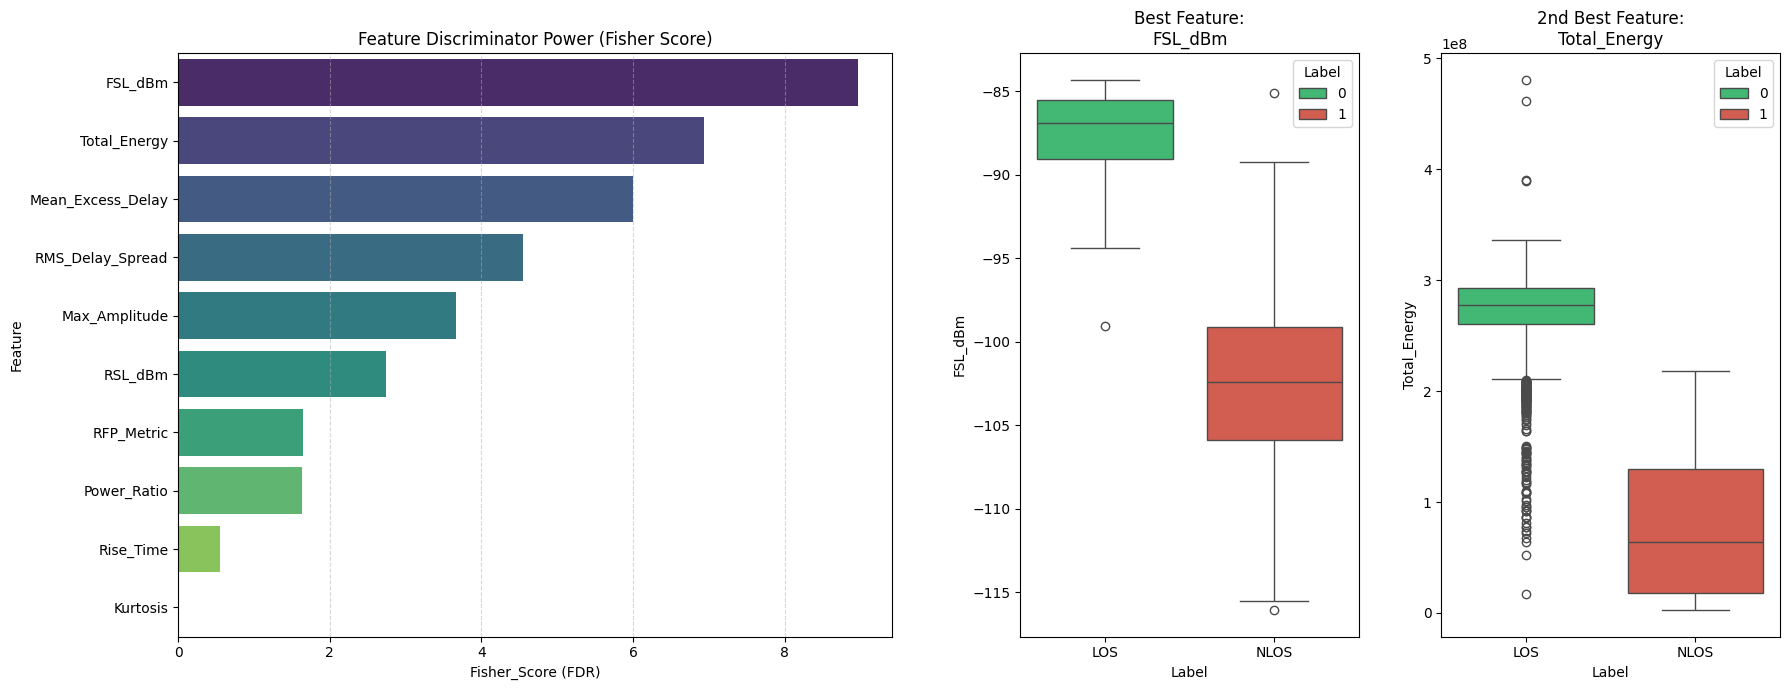

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
filepath = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")
A = 121.74  # PRF 64 MHz constant for DW1000

try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    df = pd.DataFrame() 

cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))

# ==========================================
# 2. FEATURE EXTRACTION
# ==========================================
data = []

if not df.empty:
    for idx, row in df.iterrows():
        # Get Preamble Accumulation Count (N)
        if 'RXPACC' in row: N = float(row['RXPACC'])
        elif 'RXP_ACC' in row: N = float(row['RXP_ACC'])
        else: N = 128.0 
            
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        if len(sig) == 0: continue
        
        peak_idx = np.argmax(sig)
        peak_val = sig[peak_idx]
        
        try:
            hw_fp_index = float(row['FP_INDEX']) / 64.0
        except (KeyError, ValueError):
            hw_fp_index = peak_idx 
        
        # --- DELAY SPREAD CALCULATIONS ---
        pdp = sig[int(hw_fp_index):]**2
        total_pdp_pwr = np.sum(pdp) + 1e-9
        times = np.arange(len(pdp))
        
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))

        # Standard Features
        rise_time = peak_idx - hw_fp_index
        c_max = peak_val
        raw_energy = np.sum(sig**2)
        safe_energy = max(raw_energy, 1e-9)
        
        # Power Metrics
        rsl_dbm = 10 * np.log10(safe_energy / (N**2)) - A
        fp_int_idx = int(hw_fp_index)
        fp_energy_val = np.sum(sig[max(0, fp_int_idx - 1):min(len(sig), fp_int_idx + 2)]**2)
        safe_fp_energy = max(fp_energy_val, 1e-9)
        fsl_dbm = 10 * np.log10(safe_fp_energy / (N**2)) - A
        
        rfp = rsl_dbm - fsl_dbm
        c_power_ratio = safe_fp_energy / safe_energy
        
        # Kurtosis
        window = sig[max(0, peak_idx - 10):min(len(sig), peak_idx + 30)]
        c_kurt = kurtosis(window) if len(window) > 5 else 0
            
        data.append({
            "Max_Amplitude": c_max,
            "Total_Energy": raw_energy,
            "RSL_dBm": rsl_dbm,
            "FSL_dBm": fsl_dbm,
            "RFP_Metric": rfp,
            "Power_Ratio": c_power_ratio,
            "Kurtosis": c_kurt,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Label": row['Label']
        })

    df_features = pd.DataFrame(data)

    # ==========================================
    # 3. FEATURE DISCRIMINATOR ANALYSIS
    # ==========================================
    feature_list = [
        "RFP_Metric", "Power_Ratio", "Kurtosis", 
        "Rise_Time", "RSL_dBm", "FSL_dBm", 
        "Total_Energy", "Max_Amplitude",
        "Mean_Excess_Delay", "RMS_Delay_Spread"
    ]
    
    discriminator_data = []
    los_data = df_features[df_features['Label'] == 0]
    nlos_data = df_features[df_features['Label'] == 1]
    
    for feat in feature_list:
        corr = df_features[feat].corr(df_features['Label'])
        mu0, mu1 = los_data[feat].mean(), nlos_data[feat].mean()
        var0, var1 = los_data[feat].var(), nlos_data[feat].var()
        fisher_score = ((mu0 - mu1)**2) / (var0 + var1 + 1e-9)
        try:
            auc = roc_auc_score(df_features['Label'], df_features[feat])
            auc = max(auc, 1 - auc) 
        except:
            auc = 0.5

        discriminator_data.append({
            "Feature": feat,
            "Fisher_Score (FDR)": fisher_score,
            "ROC_AUC": auc,
            "Correlation": corr
        })
    
    df_power = pd.DataFrame(discriminator_data).sort_values(by="Fisher_Score (FDR)", ascending=False)

    print("\nFEATURE DISCRIMINATOR POWER TABLE")
    print("=" * 85)
    print(f"{'Feature':<20} | {'Fisher (FDR)':<12} | {'ROC AUC':<10} | {'Correlation':<12}")
    print("-" * 85)
    for _, row in df_power.iterrows():
        print(f"{row['Feature']:<20} | {row['Fisher_Score (FDR)']:<12.4f} | {row['ROC_AUC']:<10.4f} | {row['Correlation']:<12.4f}")
    print("=" * 85)

    # ==========================================
    # 4. VISUALIZATION
    # ==========================================
    plt.figure(figsize=(18, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x="Fisher_Score (FDR)", y="Feature", data=df_power, hue="Feature", palette="viridis")
    plt.title("Feature Discriminator Power (Fisher Score)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    top_2_features = df_power['Feature'].head(2).values
    plt.subplot(1, 4, 3) 
    sns.boxplot(x='Label', y=top_2_features[0], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"Best Feature:\n{top_2_features[0]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])
    
    plt.subplot(1, 4, 4)
    sns.boxplot(x='Label', y=top_2_features[1], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"2nd Best Feature:\n{top_2_features[1]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])

    plt.tight_layout()
    plt.show()

- Metric,LOS (4.55m),NLOS (7.79m),LNN Conclusion
- MaxAmp,High (>5000),Low (~800-1300),Blockage is present.
- Rise_ns,Fast (~3-5ns),Slow (~6-9ns),Leading edge is obstructed.
- Width,Narrow (~3-5),Broad (~8-21),Signal is reflecting/scattering.
- MED,Low (<9),High (>14),Energy is delayed by geometry.